# Reformatting .pkl to panel data

Expect inputs in .pkl:
- combined jstor + scopus metadata
- author names and affiliations data
- references data
- tables, figures and equations data


Output:
- flattened versions

REC:
- 013, 023


In [37]:
import pandas as pd
# from unidecode import unidecode
from datetime import date
import numpy as np
import time
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pickle
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.pipeline import make_pipeline



scaler = StandardScaler()


pd.set_option('display.max_colwidth', 100)

pd.set_option('display.max_rows', None)

In [38]:
base_path="/Users/sijiawu/Work/Thesis/Data/Affiliations/"
data_base_path="/Users/sijiawu/Work/Thesis/Data/"
nets_path="/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/"
pdf_base_path="/Users/sijiawu/Dropbox/80YearsEconomicResearch/Data/0_PDF/"

In [74]:
proc_auths_all = pd.read_pickle(base_path+"auth_proc_w_aff_flat.pkl")
aff_sub=pd.read_pickle(base_path+"affiliations_combined_sub.pkl")
j_data=pd.read_pickle(data_base_path+"Combined/022_merged_proc_scopus_inception_with_auth_split_2020_content_type_corrected.pkl")
all_refs=pd.read_excel('../031_proc_refs_full_set/refs_1940_2020.xlsx')
relevant=pd.read_excel('../031_proc_refs_full_set/refs_1940_2020_top5.xlsx')

In [75]:
def compute_jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [76]:
proc_auths_all.columns

Index(['auth_ord', 'raw', 'init', 'suffix', 'a1', 'a2', 'a3', 'last', 'affs',
       'year', 'content_type', 'jid', 'url', 'a1_order', 'a2_order',
       'a3_order', 'init_order', 'fl', 'a1_tk_count', 'ini', 'inil', 'r_a1',
       'r_a1_name', 'p_a1', 'p_a1_name', 'resolution'],
      dtype='object')

In [77]:
j_data["id"]=j_data["URL"].str.split("/").str[-1]
relevant["id_o"]=relevant["id_o"].astype(str)
relevant["year_o"]=relevant["year_o"].astype(int)
proc_auths_all["id_o"]=proc_auths_all["url"].str.split("/").str[-1]
proc_auths_all["a1_order_str"]=proc_auths_all["a1_order"].astype(str)
relevant_sub=relevant[["ref_ord", "id_o", "year_o","match_id"]]

In [78]:
for i in proc_auths_all['id_o'].unique():
    if "." in i:
        print(i)

In [79]:
j_data["page_start"]=j_data["pages"].str.split('-').str[0]
j_data["page_end"]=j_data["pages"].str.split('-').str[-1]

In [80]:
ex_content=['MISC', 'Errata','Discussion', 'Review', 'Review2']
content=['Article', 'Comment', 'Reply', 'Rejoinder']

In [81]:
j_data.content_type.unique()

array(['Article', 'MISC', 'Comment', 'Reply', 'Errata', 'Rejoinder',
       'Discussion', 'Review', 'Correction', 'Review2'], dtype=object)

In [82]:
j_data[['pages',
       'year', 'ISSN', 'abstract', 'URL', 'publisher', 'content_type', 'type',
       'jid', 'author_split', 'urldate', 'reviewed-author', 'uploaded',
       'title_10', 'URL_og', 'number_og', 'title_og', 'author_og', 'pages_og',]].head()

,pages,year,ISSN,abstract,URL,publisher,content_type,type,jid,author_split,urldate,reviewed-author,uploaded,title_10,URL_og,number_og,title_og,author_og,pages_og
0,1363-1398,2020,0033-5533,"News reports and communication are inherently constrained by space, time, and attention. As a re...",https://doi.org/10.1093/qje/qjaa012,Oxford University Press,Article,N,qje,"[Enke, Benjamin]",NaN,NaN,NaN,NaN,https://doi.org/10.1093/qje/qjaa012,3,What You See Is All There Is*,"Enke, Benjamin",1363-1398
1,nan,2020,"00028282, 19447981",NaN,https://www.jstor.org/stable/26966477,American Economic Association,MISC,N,aer,NaN,2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966477,12,Front Matter,NaN,NaN
2,3705-3747,2020,"00028282, 19447981",African agricultural markets are characterized by low farmer revenues and high consumer food pri...,https://www.jstor.org/stable/26966478,American Economic Association,Article,N,aer,"[Lauren Falcao Bergquist, Michael Dinerstein]",2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966478,12,Competition and Entry in Agricultural Markets: Experimental Evidence from Kenya,Lauren Falcao Bergquist and Michael Dinerstein,3705-3747
3,3748-3785,2020,"00028282, 19447981",We present a new equilibrium search model where consumers initially search among discount opport...,https://www.jstor.org/stable/26966479,American Economic Association,Article,N,aer,"[Dominic Coey, Bradley J. Larsen, Brennan C. Platt]",2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966479,12,Discounts and Deadlines in Consumer Search,Dominic Coey and Bradley J. Larsen and Brennan C. Platt,3748-3785
4,3786-3816,2020,"00028282, 19447981",We formalize the argument that political disagreements can be traced to a “clash of narratives.”...,https://www.jstor.org/stable/26966480,American Economic Association,Article,N,aer,"[Kfir Eliaz, Ran Spiegler]",2023-09-04 00:00:00,NaN,1.0,NaN,https://www.jstor.org/stable/26966480,12,A Model of Competing Narratives,Kfir Eliaz and Ran Spiegler,3786-3816


In [83]:
proc_auths_all.shape #46436

(46436, 28)

In [84]:
j_data.columns

Index(['issue_url', 'author', 'title', 'journal', 'volume', 'number', 'pages',
       'year', 'ISSN', 'abstract', 'URL', 'publisher', 'content_type', 'type',
       'jid', 'author_split', 'urldate', 'reviewed-author', 'uploaded',
       'title_10', 'URL_og', 'number_og', 'title_og', 'author_og', 'pages_og',
       'j_fix', 'scopus_jid', 'scopus_id', 'scopus_authorgroup',
       'scopus_authors', 'scopus_affiliations', 'scopus_references',
       'scopus_author_full_names', 'scopus_title', 'scopus_year',
       'scopus_source_title', 'scopus_volume', 'scopus_issue', 'scopus_art_no',
       'scopus_page_start', 'scopus_page_end', 'scopus_page_count',
       'scopus_cited_by', 'scopus_doi', 'scopus_abstract', 'scopus_publisher',
       'scopus_document_type', 'scopus_publication_stage',
       'scopus_open_access', 'scopus_source', 'scopus_eid', 'scopus_title_og',
       'scopus_volume_og', 'scopus_issue_og', 'scopus_page_start_og',
       'scopus_page_end_og', 'scopus_year_og', 's_fix', 

In [85]:
auth_counts=proc_auths_all["id_o"].value_counts().reset_index()
auth_page_count=auth_counts.merge(j_data[["id","page_count"]], left_on="id_o", right_on="id", how="left").drop_duplicates().drop(columns=["id"])
auth_page_count["points"]=auth_page_count["page_count"]/(auth_page_count["count"]+1)

In [86]:
proc_auths_all=proc_auths_all.merge(auth_page_count, on="id_o", how="left")

In [87]:
auth_point_years=proc_auths_all[["resolution", "year", "points"]].groupby(['year', 'resolution'])['points'].sum().reset_index()

In [88]:
proc_auths_all["c_count"]=proc_auths_all["count"]-1

In [89]:
proc_auths_all.loc[0,"affs"].union(proc_auths_all.loc[1,"affs"])

{'harvard university',
 'national bureau of economic research - nber',
 'university of michigan'}

In [90]:
def lag_count(lag, cat):
    auth_lags=[]
    auth_counts=[]
    paper_counts=[]
    auth_affs=[]
    for i in range(1940,2021,1):
        authpoint=auth_point_years[(auth_point_years["year"]<=i)&(auth_point_years["year"]>i-lag)]
        tem=authpoint.groupby([cat])['points'].sum().reset_index()
        tem=tem.rename(columns={"points":"points"+str(lag)})
        tem["year"+str(lag)]=i
        auth_lags.append(tem)

        authcount=proc_auths_all[(proc_auths_all["year"]<=i)&(proc_auths_all["year"]>i-lag)]
        tem=authcount[[cat, "year", "c_count"]].groupby([cat])['c_count'].sum().reset_index()
        tem=tem.rename(columns={"c_count":"c_counts"+str(lag)})
        tem["year"+str(lag)]=i
        auth_counts.append(tem)

        tem=authcount[[cat, "year", "c_count"]].groupby([cat])['c_count'].count().reset_index()
        tem=tem.rename(columns={"c_count":"p_counts"+str(lag)})
        tem["year"+str(lag)]=i
        paper_counts.append(tem)

        redproccombo=proc_auths_all[(proc_auths_all["year"]>i-lag)&(proc_auths_all["year"]<=i)][[cat,"affs","year"]].groupby(cat).agg({
            'affs': lambda x: set().union(*x),
            'year': list,  # Keeping the first year since they're all the same in this sample
            cat: 'first'  # Keep track of which cat values were grouped
        }).reset_index(drop=True)
        redproccombo=redproccombo.rename(columns={"year":"all_years"+str(lag), "affs":"affs"+str(lag)})
        redproccombo["year"+str(lag)]=i
        auth_affs.append(redproccombo)


    return (pd.concat(auth_lags) , pd.concat(auth_counts), pd.concat(paper_counts),pd.concat(auth_affs))

In [91]:
auth_lag_10_df, auth_c_10_df, auth_p_10_df, auth_affs_10_df = lag_count(10,"resolution")
auth_lag_5_df, auth_c_5_df, auth_p_5_df, auth_affs_5_df = lag_count(5,"resolution")
auth_lag_20_df, auth_c_20_df, auth_p_20_df, auth_affs_20_df = lag_count(20,"resolution")

In [92]:
auth_affs_10_df.head()

,affs10,all_years10,resolution,year10
0,{birmingham united kingdom (city)},[1940],a. j. wensley,1940
1,{university of chicago},[1940],aaron director,1940
2,{columbia university},"[1940, 1940]",abba p. lerner,1940
3,{columbia university},[1940],abraham wald,1940
4,{iowa state university},[1940],adolf kozlik,1940


In [93]:
auth_comps_10=auth_lag_10_df.merge(auth_c_10_df, left_on=["resolution", "year10"], right_on=["resolution", "year10"]).merge(auth_p_10_df, left_on=["resolution", "year10"], right_on=["resolution", "year10"]).merge(auth_affs_10_df, left_on=["resolution", "year10"], right_on=["resolution", "year10"])
auth_comps_20=auth_lag_20_df.merge(auth_c_20_df, left_on=["resolution", "year20"], right_on=["resolution", "year20"]).merge(auth_p_20_df, left_on=["resolution", "year20"], right_on=["resolution", "year20"]).merge(auth_affs_20_df, left_on=["resolution", "year20"], right_on=["resolution", "year20"])
auth_comps_5=auth_lag_5_df.merge(auth_c_5_df, left_on=["resolution", "year5"], right_on=["resolution", "year5"]).merge(auth_p_5_df, left_on=["resolution", "year5"], right_on=["resolution", "year5"]).merge(auth_affs_5_df, left_on=["resolution", "year5"], right_on=["resolution", "year5"])

In [94]:
a1_lags_points=auth_comps_20.merge(auth_comps_10, left_on=["resolution", "year20"], right_on=["resolution", "year10"], how ="left").merge(auth_comps_5, left_on=["resolution", "year20"], right_on=["resolution", "year5"], how ="left").drop(columns=["year10", "year5"]).rename(columns={"year20":"year"})

In [95]:
a1_lags_points.head()

,resolution,points20,year,c_counts20,p_counts20,affs20,all_years20,points10,c_counts10,p_counts10,affs10,all_years10,points5,c_counts5,p_counts5,affs5,all_years5
0,a. j. wensley,6.666667,1940,1,1,{birmingham united kingdom (city)},[1940],6.666667,1.0,1.0,{birmingham united kingdom (city)},[1940],6.666667,1.0,1.0,{birmingham united kingdom (city)},[1940]
1,aaron director,5.500000,1940,0,1,{university of chicago},[1940],5.500000,0.0,1.0,{university of chicago},[1940],5.500000,0.0,1.0,{university of chicago},[1940]
2,abba p. lerner,6.000000,1940,0,2,{columbia university},"[1940, 1940]",6.000000,0.0,2.0,{columbia university},"[1940, 1940]",6.000000,0.0,2.0,{columbia university},"[1940, 1940]"
3,abraham wald,16.000000,1940,0,1,{columbia university},[1940],16.000000,0.0,1.0,{columbia university},[1940],16.000000,0.0,1.0,{columbia university},[1940]
4,adolf kozlik,4.500000,1940,0,1,{iowa state university},[1940],4.500000,0.0,1.0,{iowa state university},[1940],4.500000,0.0,1.0,{iowa state university},[1940]


In [96]:
def build_coauthorship_network(collabs):
    G = nx.Graph()
    G.add_nodes_from(list(collabs.index))
    unique_pairs = list(combinations(collabs.index, 2))

    for i in unique_pairs:
        if collabs.loc[i[0],i[1]]!=0:
            G.add_edge(i[0], i[1], weight=collabs.loc[i[0],i[1]])
    return G

def get_network_features(G, author1, author2):
    try:
        distance = nx.shortest_path_length(G, source=author1, target=author2)
    except nx.NetworkXNoPath:
        distance = np.inf  # No path exists

    num_paths = len(list(nx.all_shortest_paths(G, source=author1, target=author2))) if distance != np.inf else 0
    return distance, num_paths

def compute_cosine_similarity(matrix):
    m_array = matrix.values
    cosine_sim = cosine_similarity(m_array)
    authors = matrix.index
    cosine_sim_df = pd.DataFrame(cosine_sim, index=authors, columns=authors)
    return cosine_sim_df

def cit_matrix(aff_auths, order, cit_data):
    # Merge to get citations at author level
    print(cit_data.shape)
    df_citations = cit_data.merge(aff_auths[[order, "id_o"]], on="id_o")
    print(df_citations.shape)
    matrix = df_citations.pivot_table(
        index=order, columns="match_id", aggfunc="size", fill_value=0
    )
    co_simm=compute_cosine_similarity(matrix)
    return {"matrix":matrix,"sim_matrix":co_simm}

def collab_matrix(aff_auths, order):
    authors = aff_auths[order].unique()
    author_index = {author: idx for idx, author in enumerate(authors)}
    matrix_size = len(authors)
    collab_matrix = np.zeros((matrix_size, matrix_size), dtype=int)
    grouped_papers = aff_auths.groupby("url")[order].apply(list)

    for authors_list in grouped_papers:
        for author1, author2 in combinations(authors_list, 2):
            idx1, idx2 = author_index[author1], author_index[author2]
            collab_matrix[idx1, idx2] += 1
            collab_matrix[idx2, idx1] += 1  

    collaboration_matrix = pd.DataFrame(collab_matrix, index=authors, columns=authors)
    
    return collaboration_matrix
    
def reduce_affs_jacc_sim(aff_auths, order, cits):
    collabs=collab_matrix(aff_auths, order)
    # o={}
    # for i in aff_auths.index:
    #     if aff_auths.loc[i,order] in o.keys():
    #         o[aff_auths.loc[i,order]].update(aff_auths.loc[i,"affs"])  # Merge sets
    #     else:
    #         o[aff_auths.loc[i,order]] = aff_auths.loc[i,"affs"]

    # Group by the "order" column and merge sets efficiently
    o = aff_auths.groupby(order)["affs"].agg(set.union).to_dict()

    cit_mat=cit_matrix(aff_auths, order, cits)
    
    o_proc=[]
    pairs = list(combinations(list(o.keys()), 2))
    # print(cit_mat['sim_matrix'].head())
    
    G_t = build_coauthorship_network(collabs)
    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G_t))  # Dictionary of shortest paths
    
    # Convert to DataFrame for fast lookups
    shortest_paths_df = pd.DataFrame(
        [(src, tgt, dist) for src, targets in all_shortest_paths.items() for tgt, dist in targets.items()],
        columns=["pair_1", "pair_2", "distance"]
    )

    print(shortest_paths_df.columns)
    # Compute number of shortest paths
    num_paths_dict = {
        (a, b): len(list(nx.all_shortest_paths(G_t, a, b))) if b in all_shortest_paths[a] else 0
        for a, targets in all_shortest_paths.items()
        for b in targets
    }

    # Add num_paths to DataFrame
    shortest_paths_df["num_paths"] = shortest_paths_df.apply(lambda row: num_paths_dict.get((row["pair_1"], row["pair_2"]), 0), axis=1)

    # Convert pairs list to DataFrame and merge precomputed network data
    # pairs_df = pd.DataFrame(pairs, columns=["pair_1", "pair_2"])
    # pairs_df = pairs_df.merge(shortest_paths_df, on=["pair_1", "pair_2"], how="left").fillna({"distance": np.inf, "num_paths": 0})



    for i in pairs:
        # distance, num_paths = get_network_features(G_t, i[0], i[1])
        # network_proximity = 1 / distance if distance != np.inf else 0
        # log_num_paths = np.log(num_paths + 1)  # Avoid log(0)
        temp={ 
                       "pair_1":i[0], 
                       "pair_2":i[1],
                       "aff_jacc_sim":compute_jaccard_similarity(o[i[0]],o[i[1]]),
                       "collabs": collabs.loc[i[0],i[1]],
                    #    "distance": distance,
                    #    "network_proximity": network_proximity,
                    #    "log_num_paths":log_num_paths
        }
        
        
        if (i[0] in cit_mat["sim_matrix"].index) & (i[1] in cit_mat["sim_matrix"].index):
            temp["cit_cos_sim"]=cit_mat["sim_matrix"].loc[i[0],i[1]]
        else:
            temp["cit_cos_sim"]=0
        o_proc.append(temp)

    combo=pd.DataFrame(o_proc).merge(shortest_paths_df, on=["pair_1", "pair_2"], how="left").fillna({"distance": np.inf, "num_paths": 0})
    
    o_flat=[]
    for i in o.keys():
        o_flat.append({"order": i,"affs": o[i]})

    
    return {"sims_pairs":combo, "aff_sets":o, "aff_flat_sets": pd.DataFrame(o_flat),  "collabs": collabs, "cit":cit_mat, "auth_net": G_t}



def data_prep(t, duration, order):
    print(t)
    aff_t=proc_auths_all[(proc_auths_all['year']<t+duration)&(proc_auths_all['year']>=t)].reset_index(drop=True)
    cit_t=relevant_sub[(relevant_sub["year_o"]>=t)&(relevant_sub["year_o"]<t+duration)].reset_index(drop=True)
    j_t=j_data[(j_data["year"]>=t)&(j_data["year"]<t+duration)][['id', "title", "jid", "year", "content_type"]].reset_index(drop=True)
    a=time.time()
    jaccs=reduce_affs_jacc_sim(aff_t, order, cit_t)
    jaccs["j_data_t"]=j_t
    b=time.time()
    print(b-a)
    # print()
    return jaccs


In [97]:
# jacc_sims_10={}

# for i in range(1940,2020,10):
#     jacc_sims_10[i]=data_prep(i,10, 'a1_order')

# jacc_sims_20={}

# for i in range(1940,2020,20):
#     jacc_sims_20[i]=data_prep(i,20, 'a1_order')

In [98]:
def pickle_it(filepath, data):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

def get_pickle(filepath):
    data=None
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data

In [99]:

# Load dataset (Assuming it has 'Paper_ID', 'Author', and 'Year')
df = proc_auths_all[["id_o","resolution", "year"]].rename(columns={'id_o': 'Paper_ID', 'resolution': 'Author', "year":"Year"})
# Step 1: Expand multi-author papers into pairwise relationships
df_expanded = df.groupby(["Paper_ID", "Year"])['Author'].apply(
    lambda x: list(combinations(x, 2)) if len(x) > 1 else [(x.iloc[0], None)]
).explode()

# Convert tuples to separate columns
df_expanded = pd.DataFrame(df_expanded.tolist(), index=df_expanded.index, columns=["Author", "Coauthor"]).reset_index()

# Keep necessary columns
df_expanded = df_expanded[["Author", "Coauthor", "Year"]]
df_expanded_alt=df_expanded[["Author", "Coauthor", "Year"]].fillna(-1)

# Step 2: Count occurrences of coauthorship per year
df_expanded["Coauthorship_Count"] = df_expanded.groupby(["Author", "Coauthor", "Year"])['Year'].transform('count')
df_expanded_alt["Coauthorship_Count"] = df_expanded_alt.groupby(["Author", "Coauthor", "Year"])['Year'].transform('count')


# Determine first and last publication year for each author
author_first_pub = df.groupby("Author")["Year"].min()
author_last_pub = df.groupby("Author")["Year"].max()

In [71]:
# Step 3: Define year range
start_year = 1949
end_year = 2020
window_10=10
window_5=5
window_20=20

In [100]:

def cent_measures(G):
    max_eig=max(nx.adjacency_spectrum(G))
    complex_num=max_eig
    float_value = float(complex_num.real)
    # Check if imaginary part is effectively zero
    # has_imaginary_part = not np.isclose(complex_num.imag, 0)
    # components = list(nx.connected_components(G))
    # print(f"Network has {len(components)} disconnected components")
    # Convert to float (only if it's safe to do so)
    # if has_imaginary_part:
        # print(f"Warning: Number has imaginary component: {complex_num.imag}")
        # Handle appropriately - either use abs() or raise error
    # else:
        # float_value = float(complex_num.real)
        # print(f"Converted to float: {float_value}")
    centrality_measures = {
        "degree": nx.degree_centrality(G),
        "betweenness": nx.betweenness_centrality(G),
        "closeness": nx.closeness_centrality(G),
        "eigenvector": nx.eigenvector_centrality(G),
        "pagerank": nx.pagerank(G),
        # "katz": nx.katz_centrality(G, alpha=1/(max_eig+1), max_iter=100000),
        'katz':nx.katz_centrality_numpy(G, alpha=1/(float_value+1)),
        "harmonic": nx.harmonic_centrality(G),
    }
    return centrality_measures



In [101]:
df_expanded_alt.head()

,Author,Coauthor,Year,Coauthorship_Count
0,arnold c. harberger,-1,1998,1
1,dennis n. epple,richard e. romano,1998,1
2,joseph e. harrington,-1,1998,1
3,peter a. diamond,-1,1998,2
4,benjamin e. hermalin,michael s. weisbach,1998,1


In [105]:
df_expanded_alt.head()

,Author,Coauthor,Year,Coauthorship_Count
0,arnold c. harberger,-1,1998,1
1,dennis n. epple,richard e. romano,1998,1
2,joseph e. harrington,-1,1998,1
3,peter a. diamond,-1,1998,2
4,benjamin e. hermalin,michael s. weisbach,1998,1


In [195]:

def generate_networks(start_year, window):
    for t in range(start_year, end_year + 1):
        w=window-1
        net_dist=[]
        a=time.time()
        print(str(t) + " to "+str(t-w))
        min_year = t - w  # Define 10-year rolling window
        max_year = t
        
        # Filter data for the current 10-year period
        df_window = df_expanded_alt[(df_expanded_alt["Year"] >= min_year) & (df_expanded_alt["Year"] <= max_year)]
        
        # Build coauthorship network
        G = nx.Graph()
        for _, row in df_window.iterrows():
            if row["Coauthor"]==-1:
                G.add_node(row["Author"], weight=row["Coauthorship_Count"])
            else:
                G.add_edge(row["Author"], row["Coauthor"], weight=row["Coauthorship_Count"])
        
        nx.write_gexf(G, nets_path+str(t)+"-"+str(min_year)+"_"+str(window)+"Y.gexf", encoding='utf-8')
        # print(nets_path+str(t)+"-"+str(min_year)+"_"+str(window)+"Y.gexf")
        b=time.time()
        print(b-a)

generate_networks(1940, 5)
generate_networks(1940, 10)
generate_networks(1940, 20)

1940 to 1936
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1940-1936_5Y.gexf
0.011209964752197266
1941 to 1937
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1941-1937_5Y.gexf
0.009619951248168945
1942 to 1938
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1942-1938_5Y.gexf
0.016290903091430664
1943 to 1939
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1943-1939_5Y.gexf
0.019802093505859375
1944 to 1940
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1944-1940_5Y.gexf
0.024708986282348633
1945 to 1941
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1945-1941_5Y.gexf
0.02507328987121582
1946 to 1942
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1946-1942_5Y.gexf
0.028532028198242188
1947 to 1943
/Users/sijiawu/Work/80YearsEconomicResearch/032_auth_graph_gen/networks/1947-1943_5Y.gexf
0.02634596824645996
1948 to 19

In [196]:
# nx simple paths usage takes way too long

def count_paths_with_exact_length(G, source, target, length):
    return sum(1 for path in nx.all_simple_paths(G, source, target, cutoff=length) 
               if len(path) - 1 == length)


def find_kth_shortest_path(G,source, target, k=2):
    results = defaultdict(dict)

    all_paths = [(len(path)-1, path) for path in nx.all_simple_paths(G, source, target)] #add cutoff
    all_paths.sort()


    # Group paths by length
    path_groups = {}
    for length, path in all_paths:
        if length not in path_groups:
            path_groups[length] = []
        path_groups[length].append(path)
    
    # Get distinct lengths and sort them
    lengths = sorted(path_groups.keys())
    
    # If we have at least k different lengths, return one path from the kth group
    if len(lengths) >= k:
        kth_shortest_length = lengths[k-1]
        kth_shortest_path = path_groups[kth_shortest_length][0]  # Get one path of this length
        results[source][target] = (kth_shortest_path, "Success")
    else:
        results[source][target] = ([], f"Only {len(lengths)} path lengths found")

    return results

def find_kth_shortest_paths_all_pairs(G, k=2, limit=5):
    """
    Find the kth shortest path for each pair of nodes in graph G.
    
    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    k : int
        Which shortest path to find (1 for shortest, 2 for second shortest, etc.)
    
    Returns:
    --------
    dict of dict
        A nested dictionary where result[source][target] contains a tuple of
        (path, status) where path is the kth shortest path and status explains
        any issues if the path doesn't exist.
    """
    results = defaultdict(dict)
    
    for source in G.nodes():
        for target in G.nodes():
            if source == target:
                # Skip self-loops
                results[source][target] = ([], "Same node")
                continue

            # Check if there's a path between source and target
            if not nx.has_path(G, source, target):
                results[source][target] = ([], "No path exists")
                continue
            
            try:
                # Get all simple paths and their lengths
                all_paths = [(len(path)-1, path) for path in nx.all_simple_paths(G, source, target, cutoff=limit)]
                
                # Sort paths by length
                all_paths.sort()
                
                # Group paths by length
                path_groups = {}
                for length, path in all_paths:
                    if length not in path_groups:
                        path_groups[length] = []
                    path_groups[length].append(path)
                
                # Get distinct lengths and sort them
                lengths = sorted(path_groups.keys())
                
                # If we have at least k different lengths, return one path from the kth group
                if len(lengths) >= k:
                    kth_shortest_length = lengths[k-1]
                    kth_shortest_path = path_groups[kth_shortest_length][0]  # Get one path of this length
                    results[source][target] = (kth_shortest_path, "Success")
                else:
                    results[source][target] = ([], f"Only {len(lengths)} path lengths found")
            except Exception as e:
                results[source][target] = ([], f"Error: {e}")
    
    return results


In [197]:
# alt count simple paths up to a point, 

def count_simple_paths_of_length(G, source, target, length):
    """
    Counts the number of simple paths of exact length between source and target.
    
    Parameters:
    -----------
    G : NetworkX graph
    source : node
        Starting node
    target : node
        Ending node
    length : int
        Desired path length (number of edges)
        
    Returns:
    --------
    int
        Number of simple paths with exactly the specified length
    """
    # Counter to keep track of the number of paths
    path_count = [0]  # Using list for mutable reference in nested function
    
    # Keep track of visited nodes to ensure simple paths
    visited = {source: True}
    
    def dfs(current, steps_remaining):
        # If we've reached the target with the exact length
        if current == target and steps_remaining == 0:
            path_count[0] += 1
            return
        
        # If we've used all steps but haven't reached target, or reached target too early
        if steps_remaining == 0 or current == target:
            return
            
        # Continue DFS
        for neighbor in G.neighbors(current):
            if neighbor not in visited:
                visited[neighbor] = True
                dfs(neighbor, steps_remaining - 1)
                del visited[neighbor]  # Backtrack
    
    # Start DFS from source
    dfs(source, length)
    return path_count[0]

In [198]:
combo=author_first_pub.reset_index().rename(columns={"Year": "First_Year"}).merge(author_last_pub.reset_index().rename(columns={"Year": "Last_Year"}), on="Author").merge(df[["Author"]].groupby("Author").first().reset_index(), on="Author")
combo.head()

,Author,First_Year,Last_Year
0,a. a. brewer,1975,1975
1,a. a. payne,2003,2003
2,a. a. ryvkin,1979,1979
3,a. a. sampson,1978,1978
4,a. a. schmid,1967,1967


In [199]:
#consider removing, resolution column should have no null values
df_ex_na=df_expanded[df_expanded["Coauthor"].isna()==False].reset_index(drop=True)
df_ex_na["Ai"]=df_ex_na["Author"]
df_ex_na["Ci"]=df_ex_na["Coauthor"]
df_ex_na['Author'] = df_ex_na[['Ai', 'Ci']].min(axis=1).astype(str)
df_ex_na['Coauthor'] = df_ex_na[['Ai', 'Ci']].max(axis=1).astype(str)
df_ex_na.shape

(23582, 6)

In [200]:
collabs=df_ex_na[["Author","Coauthor"]].groupby(["Author","Coauthor"]).first().reset_index()
collabs_merge=collabs.merge(combo, on="Author").merge(combo.rename(columns={"Author":"Coauthor","First_Year":"First_Year_C", "Last_Year":"Last_Year_C", "a1":"a1_C", "last":"last_C"}), on="Coauthor")
collabs_merge.shape

(18296, 6)

In [201]:
collabs_merge.head()

,Author,Coauthor,First_Year,Last_Year,First_Year_C,Last_Year_C
0,a. a. payne,james andreoni,2003,2003,1987,2020
1,a. a. ryvkin,i. y. vakhutinsky,1979,1979,1979,1979
2,a. a. ryvkin,l. m. dudkin,1979,1979,1979,1979
3,a. anastasopoulos,stratis kounias,1975,1975,1975,1975
4,a. b. araoz,h. b. malmgren,1961,1961,1961,1961


In [202]:
df_yijt = {}
a=0
for x in collabs_merge.index:
    i=collabs_merge.loc[x,'Author']
    j=collabs_merge.loc[x,'Coauthor']
    ti_0=collabs_merge.loc[x,'First_Year']
    tj_0=collabs_merge.loc[x,'First_Year_C']
    tij_0=max(ti_0,tj_0)
    ti_2=collabs_merge.loc[x,'Last_Year']
    tj_2=collabs_merge.loc[x,'Last_Year_C']
    tij_2=min(ti_2,tj_2)
    collab_ij=df_ex_na[(df_ex_na["Author"]==i)&(df_ex_na["Coauthor"]==j)]
    collab_years=collab_ij["Year"].to_list()
    # if len(collab_ij["Year"].unique())!=collab_ij.shape[0]:
    #     # print(x)
    #     a+=1
    tij_1=min(collab_ij["Year"])

    for y in range(tij_0, tij_2+1):
        if y not in collab_years:
            df_yijt[a]={"Author":i, "Coauthor":j, "tij":y, "ytij":0, "tij_1":tij_1, "tij_2":tij_2, "tij_0":tij_0, 
                        # "Paper_ID":""
                        }
            a+=1
            # print(y)
    for y in collab_ij.index:
        # print(" "+str(collab_ij.loc[y,"Year"]))
        df_yijt[a]={"Author":i, "Coauthor":j, "tij":collab_ij.loc[y,"Year"], "ytij":1, "tij_1":tij_1, "tij_2":tij_2, "tij_0":tij_0, 
                    # "Paper_ID":collab_ij.loc[y,"Paper_ID"]
                    }
        a+=1



In [203]:
df_y=pd.DataFrame(df_yijt).transpose()

In [204]:
df_y.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0
0,a. a. payne,james andreoni,2003,1,2003,2003,2003
1,a. a. ryvkin,i. y. vakhutinsky,1979,1,1979,1979,1979
2,a. a. ryvkin,l. m. dudkin,1979,1,1979,1979,1979
3,a. anastasopoulos,stratis kounias,1975,1,1975,1975,1975
4,a. b. araoz,h. b. malmgren,1961,1,1961,1961,1961


In [205]:
df_y.shape

(121331, 7)

In [206]:
df_y[df_y["tij_0"]==df_y["tij_1"]].shape

(42919, 7)

In [207]:
df_y[df_y["tij"]<=df_y["tij_1"]].shape

(58464, 7)

In [208]:
nms=["i","j","distance", "total_paths", "avg_path_length", "pij_t", "shortest_path_count"]

In [209]:
def count_second_shortest_paths(G, source, target):
    """
    Find the count of second shortest simple paths between source and target.
    
    Parameters:
    -----------
    G : NetworkX graph
    source : node
        Starting node
    target : node
        Ending node
        
    Returns:
    --------
    tuple
        (second_shortest_length, count) - Length of second shortest path and count of paths with that length
    """
    # Use Dijkstra's algorithm to find distances to all nodes
    import heapq
    from collections import defaultdict
    
    # Track distances and path counts
    # For each node, we'll store (distance, count of paths with that distance)
    distances = {node: float('infinity') for node in G.nodes()}
    distances[source] = 0
    
    # For each node, we'll maintain a sorted list of (distance, count) pairs
    path_info = defaultdict(list)
    path_info[source].append((0, 1))  # (distance, count)
    
    # Priority queue for Dijkstra's algorithm
    pq = [(0, source)]
    
    while pq:
        dist, node = heapq.heappop(pq)
        
        # Skip outdated entries
        if dist > distances[node]:
            continue
            
        # Process neighbors
        for neighbor in G.neighbors(node):
            # Get edge weight (1 for unweighted graphs)
            weight = G[node][neighbor].get('weight', 1)
            
            # Calculate new distance
            new_dist = dist + weight
            
            # If we found a new distance to this neighbor
            if new_dist <= distances[neighbor]:
                # If it's a shorter path, update distance
                if new_dist < distances[neighbor]:
                    distances[neighbor] = new_dist
                    heapq.heappush(pq, (new_dist, neighbor))
                    path_info[neighbor] = [(new_dist, 0)]  # Reset path count
                
                # Count paths with this distance
                # Find paths to 'node' with distance = dist
                for d, count in path_info[node]:
                    if d == dist:
                        # Update count for the distance at neighbor
                        for i, (nd, nc) in enumerate(path_info[neighbor]):
                            if nd == new_dist:
                                path_info[neighbor][i] = (nd, nc + count)
                                break
                        else:
                            path_info[neighbor].append((new_dist, count))
    
    # Sort path_info for the target to get shortest and second shortest
    target_info = sorted(path_info[target])
    
    # If there's only one distance or no paths
    if len(target_info) <= 1:
        return None, 0
    
    # Return second shortest distance and its count
    return target_info[1][0], target_info[1][1]

In [210]:
def shortest_path_excluding_direct(G, source, target):
    """
    Find the shortest path between source and target,
    ignoring any direct edge between them.
    
    Parameters:
    -----------
    G : NetworkX graph
    source : node
        Starting node
    target : node
        Ending node
        
    Returns:
    --------
    list
        The shortest path excluding direct connection, or None if no such path exists
    """
    # Check if a direct edge exists
    has_direct_edge = G.has_edge(source, target)
    
    if has_direct_edge:
        # Temporarily remove the direct edge
        edge_data = None
        
        # For simple graphs
        edge_data = G.get_edge_data(source, target)
        G.remove_edge(source, target)
        
        try:
            # Find the shortest path without the direct edge
            path = list(nx.all_shortest_paths(G, source, target))
            return path
        except nx.NetworkXNoPath:
            # No alternate path exists
            return None
        finally:
            G.add_edge(source, target, **edge_data)

In [ ]:

def get_coauth_net_data(year):
    updates = []
    c=0
    for t in range(1950,2021):
        
        G=nx.read_gexf(nets_path+str(t-1)+"-"+str(t-year)+"_"+str(year)+"Y.gexf")
        nodes=G.nodes
        # print(len(nodes))
        print("\r"+str(t))
        for i in df_y[df_y["tij"]==t].index:
            # c+=1
            # if c>50:
            #     break
            source=df_y.loc[i,"Author"]
            target=df_y.loc[i,"Coauthor"]
            source_conf=source in nodes
            target_conf=target in nodes
            if source_conf & target_conf:
                if nx.has_path(G, source, target):
                    if source == target:
                        continue
                    paths = list(nx.all_shortest_paths(G, source, target))
                    distance=len(paths[0])-1                
                    pij=1/distance
                    
                    if distance==1:
                        excl=shortest_path_excluding_direct(G, source, target)
                        
                        if excl==None:
                            distance=float('inf')
                            count=0
                            pij=0
                        else:
                            distance=len(excl[0])-1
                            # count=len(excl)
                            # print(count)
                            pij=1/distance
                            # print(pij)
                            
                    updates.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": distance, 
                                        "pij_t":pij,
                                        "cij_t":len(paths),
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":0
                                    }
                                )
                else:
                    updates.append(df_y.iloc[i].to_dict()|
                                    {   
                                        "tij":t,
                                        "tij-1":t-1,
                                        "Author":source,
                                        "Coauthor":target, 
                                        "distance": float('inf'),
                                        "pij_t": 0,
                                        "cij_t":0,
                                        "A":source_conf, 
                                        "C":target_conf,
                                        "E":0
                                    }
                                )
            else:
                if source_conf |target_conf:
                    updates.append(df_y.iloc[i].to_dict()|
                                        {   
                                            "tij":t,
                                            "tij-1":t-1,
                                            "Author":source,
                                            "Coauthor":target, 
                                            "distance": float('inf'),
                                            "pij_t":0, 
                                            "cij_t":0,
                                            "A":source_conf, 
                                            "C":target_conf,
                                            "E":1
                                        }
                                    )
                else:
                    updates.append(df_y.iloc[i].to_dict()|
                                        {   
                                            "tij":t,
                                            "tij-1":t-1,
                                            "Author":source,
                                            "Coauthor":target, 
                                            "distance": float('inf'),
                                            "pij_t":0, 
                                            "cij_t":0,
                                            "A":source_conf, 
                                            "C":target_conf,
                                            "E":2
                                        })
    return updates

In [212]:
updates=get_coauth_net_data(10)
updates_5=get_coauth_net_data(5)
updates_20=get_coauth_net_data(20)

upd=pd.DataFrame(updates)
upd_5=pd.DataFrame(updates_5)
upd_20=pd.DataFrame(updates_20)

# upd.to_pickle("upd.pkl")


1950
17
0.5
17
0.5
17
0.5
17
0.5
3
0.5
17
0.5
17
0.5
17
0.5
18
0.5
17
0.5
3
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
9
0.5
9
0.5
9
0.5
9
0.5
9
0.5
9
0.5
1
0.5
1
0.5
8
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
8
0.5
17
0.5
17
0.5
8
0.5
17
0.5
17
0.5
17
0.5
17
0.5
6
0.5
8
0.5
8
0.5
8
0.5
8
0.5
1
0.5
1
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
3
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
4
0.5
17
0.5
17
0.5
17
0.5
4
0.5
1
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
4
0.5
17
0.5
9
0.5
9
0.5
9
0.5
9
0.5
9
0.5
13
0.5
13
0.5
13
0.5
13
0.5
13
0.5
1
0.5
4
0.5
4
0.5
9
0.5
9
0.5
9
0.5
9
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
13
0.5
13
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
17
0.5
13
0.5
13
0.5
4
0.5
9
0.5
9
0.5

In [216]:
upd.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,cij_t,A,C,E
0,albert b. wolfe,aryness j. wickens,1950,0,1946,1950,1946,1949,2.0,0.5,1,True,True,0
1,albert b. wolfe,dexter m. keezer,1950,0,1946,1950,1941,1949,2.0,0.5,1,True,True,0
2,albert b. wolfe,donald h. wallace,1950,0,1946,1950,1940,1949,2.0,0.5,1,True,True,0
3,albert b. wolfe,e. a. goldenweiser,1950,0,1946,1950,1946,1949,2.0,0.5,1,True,True,0
4,albert b. wolfe,earl j. hamilton,1950,0,1942,1950,1940,1949,2.0,0.5,1,True,True,0


In [217]:
upd_20.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,cij_t,A,C,E
0,albert b. wolfe,aryness j. wickens,1950,0,1946,1950,1946,1949,2.0,0.5,1,True,True,0
1,albert b. wolfe,dexter m. keezer,1950,0,1946,1950,1941,1949,2.0,0.5,1,True,True,0
2,albert b. wolfe,donald h. wallace,1950,0,1946,1950,1940,1949,2.0,0.5,1,True,True,0
3,albert b. wolfe,e. a. goldenweiser,1950,0,1946,1950,1946,1949,2.0,0.5,1,True,True,0
4,albert b. wolfe,earl j. hamilton,1950,0,1942,1950,1940,1949,2.0,0.5,1,True,True,0


In [218]:
upd_20["E"].value_counts()

E
0    99179
1    14466
2     4095
Name: count, dtype: int64

In [219]:
a1_lags_points.head()

,resolution,points20,year,c_counts20,p_counts20,affs20,all_years20,points10,c_counts10,p_counts10,affs10,all_years10,points5,c_counts5,p_counts5,affs5,all_years5
0,a. j. wensley,6.666667,1940,1,1,{birmingham united kingdom (city)},[1940],6.666667,1.0,1.0,{birmingham united kingdom (city)},[1940],6.666667,1.0,1.0,{birmingham united kingdom (city)},[1940]
1,aaron director,5.500000,1940,0,1,{university of chicago},[1940],5.500000,0.0,1.0,{university of chicago},[1940],5.500000,0.0,1.0,{university of chicago},[1940]
2,abba p. lerner,6.000000,1940,0,2,{columbia university},"[1940, 1940]",6.000000,0.0,2.0,{columbia university},"[1940, 1940]",6.000000,0.0,2.0,{columbia university},"[1940, 1940]"
3,abraham wald,16.000000,1940,0,1,{columbia university},[1940],16.000000,0.0,1.0,{columbia university},[1940],16.000000,0.0,1.0,{columbia university},[1940]
4,adolf kozlik,4.500000,1940,0,1,{iowa state university},[1940],4.500000,0.0,1.0,{iowa state university},[1940],4.500000,0.0,1.0,{iowa state university},[1940]


In [220]:
upd_w_lags_10=upd.merge(a1_lags_points[["resolution","year", "points10","c_counts10","p_counts10"]], left_on=["Author", "tij-1"], right_on=["resolution", "year"], how="left").rename(columns={"points10":"p-a", "c_counts10":"co-a","p_counts10":"pa-a"}).merge(a1_lags_points[["resolution","year", "points10","c_counts10","p_counts10"]], left_on=["Coauthor", "tij-1"], right_on=["resolution", "year"], how="left").rename(columns={"points10":"p-c","c_counts10":"co-c","p_counts10":"pa-c"}).drop(columns=["resolution_x", "year_x","resolution_y", "year_y"]).fillna(0)
upd_w_lags_5=upd.merge(a1_lags_points[["resolution","year", "points5","c_counts5","p_counts5"]], left_on=["Author", "tij-1"], right_on=["resolution", "year"], how="left").rename(columns={"points5":"p-a","c_counts5":"co-a","p_counts5":"pa-a"}).merge(a1_lags_points[["resolution","year", "points5", "c_counts5","p_counts5"]], left_on=["Coauthor", "tij-1"], right_on=["resolution", "year"], how="left").rename(columns={"points5":"p-c", "c_counts5":"co-c","p_counts5":"pa-c"}).drop(columns=["resolution_x", "year_x","resolution_y", "year_y"]).fillna(0)
upd_w_lags_20=upd.merge(a1_lags_points[["resolution","year", "points20","c_counts20","p_counts20"]], left_on=["Author", "tij-1"], right_on=["resolution", "year"], how="left").rename(columns={"points20":"p-a", "c_counts20":"co-a","p_counts20":"pa-a"}).merge(a1_lags_points[["resolution","year", "points20", "c_counts20","p_counts20"]], left_on=["Coauthor", "tij-1"], right_on=["resolution", "year"], how="left").rename(columns={"points20":"p-c", "c_counts20":"co-c","p_counts20":"pa-c"}).drop(columns=["resolution_x", "year_x","resolution_y", "year_y"]).fillna(0)

upd_w_lags_10=upd_w_lags_10.merge(a1_lags_points[["resolution","year","affs10"]], left_on=["Author", "tij"], right_on=["resolution", "year"], how="left").rename(columns={"affs10":"affs-a"}).merge(a1_lags_points[["resolution","year","affs10"]], left_on=["Coauthor", "tij"], right_on=["resolution", "year"], how="left").rename(columns={"affs10":"affs-c"}).drop(columns=["resolution_x", "year_x","resolution_y", "year_y"]).fillna({})
upd_w_lags_5=upd_w_lags_5.merge(a1_lags_points[["resolution","year","affs5"]], left_on=["Author", "tij"], right_on=["resolution", "year"], how="left").rename(columns={"affs5":"affs-a"}).merge(a1_lags_points[["resolution","year","affs5"]], left_on=["Coauthor", "tij"], right_on=["resolution", "year"], how="left").rename(columns={"affs5":"affs-c"}).drop(columns=["resolution_x", "year_x","resolution_y", "year_y"]).fillna({})
upd_w_lags_20=upd_w_lags_20.merge(a1_lags_points[["resolution","year","affs20"]], left_on=["Author", "tij"], right_on=["resolution", "year"], how="left").rename(columns={"affs20":"affs-a"}).merge(a1_lags_points[["resolution","year","affs20"]], left_on=["Coauthor", "tij"], right_on=["resolution", "year"], how="left").rename(columns={"affs20":"affs-c"}).drop(columns=["resolution_x", "year_x","resolution_y", "year_y"]).fillna({})

In [221]:
proc_auths_all[proc_auths_all["resolution"]=="charles wolf, jr"]

,auth_ord,raw,init,suffix,a1,a2,a3,last,affs,year,...,r_a1_name,p_a1,p_a1_name,resolution,id_o,a1_order_str,count,page_count,points,c_count
16227,0,Charles Wolf,charles wolf,[],charles wolf,c. wolf,c. wolf,wolf,{rand corporation},1973,...,,"[""charles r. wolf""]","charles wolf, jr","charles wolf, jr",1817051,8672,2,9.0,3.0,1
16228,1,David Weinschrott,david weinschrott,[],david weinschrott,d. weinschrott,d. weinschrott,weinschrott,{rand corporation},1973,...,david weinschrott,NaN,"charles wolf, jr","charles wolf, jr",1817051,12724,2,9.0,3.0,1
18889,0,Charles Wolf,charles wolf,[],charles wolf,c. wolf,c. wolf,wolf,{rand corporation},1955,...,,"[""charles r. wolf""]","charles wolf, jr","charles wolf, jr",1821384,8672,1,17.0,8.5,0
19212,0,Charles Wolf,charles wolf,[],charles wolf,c. wolf,c. wolf,wolf,{harvard university},1952,...,,"[""charles r. wolf""]","charles wolf, jr","charles wolf, jr",1812537,8672,1,3.0,1.5,0
33733,0,Charles Wolf,charles wolf,[],charles wolf,c. wolf,c. wolf,wolf,{rand corporation},1970,...,,"[""charles r. wolf""]","charles wolf, jr","charles wolf, jr",1829934,8672,1,10.0,5.0,0
44751,0,Charles Wolf,charles wolf,[],charles wolf,c. wolf,c. wolf,wolf,{rand corporation},1973,...,,"[""charles r. wolf""]","charles wolf, jr","charles wolf, jr",1882036,8672,1,7.0,3.5,0


In [222]:
otw=0
difs=[]
for i in proc_auths_all["resolution"].unique():
    temp=proc_auths_all[proc_auths_all["resolution"]==i].sort_values('year')
    tempi=temp.index
    if len(tempi)>1:
        dif=0
        for j in range(len(tempi)-1):
            dif+=(proc_auths_all.loc[tempi[j+1],"year"]-proc_auths_all.loc[tempi[j],"year"])
        avg_dif=dif/(len(tempi)-1)
        # print(avg_dif)
        difs.append({"resolution":i,"avg-d":avg_dif,"dif":dif,"pubs":len(tempi)})
    else:
        otw+=1
        difs.append({"resolution":i,"avg-d":0,"dif":0,"pubs":len(tempi)}) 

authstat=pd.DataFrame(difs)       

In [223]:
authstat.head()

,resolution,avg-d,dif,pubs
0,benjamin enke,0.5,2,5
1,lauren f. bergquist,1.0,1,2
2,michael dinerstein,2.0,2,2
3,dominic coey,0.0,0,1
4,bradley j. larsen,4.0,4,2


In [224]:
otw

8501

In [225]:
sum(authstat[authstat["pubs"]>1]["avg-d"])/authstat[authstat["pubs"]>1].shape[0]

4.180045119522343

In [226]:

sum(authstat[authstat["pubs"]>1]["avg-d"])/authstat[authstat["pubs"]>1].shape[0]

4.180045119522343

In [227]:
authstat[authstat["avg-d"]>0].shape[0]/2

3433.0

In [228]:
list(authstat[authstat["avg-d"]>0]["avg-d"].sort_values())[3529]

3.0

In [229]:
authstat[authstat["avg-d"]>20].sort_values("avg-d").shape

(83, 4)

In [230]:
collabs20=list(authstat[authstat["avg-d"]>20]["resolution"].values)
collabs10=list(authstat[authstat["avg-d"]>10]["resolution"].values)

In [231]:
authstat[authstat["avg-d"]>10].sort_values("avg-d").shape

(481, 4)

In [232]:
collaborators=list(set(upd_w_lags_10["Author"].unique()).union(set(upd_w_lags_10["Coauthor"].unique())))

In [233]:
len(set(collaborators).intersection(set(collabs10)))

372

In [234]:
len(set(collaborators).intersection(set(collabs20)))

60

In [235]:
len(proc_auths_all["resolution"].unique())

15613

In [236]:
upd_w_lags_10[upd_w_lags_10["affs-a"]==0].head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,C,E,p-a,co-a,pa-a,p-c,co-c,pa-c,affs-a,affs-c


In [237]:
upd_w_lags_10["avg_p"]=(upd_w_lags_10["p-a"]+upd_w_lags_10["p-c"])/2
upd_w_lags_10["abs_p"]=abs(upd_w_lags_10["p-a"]-upd_w_lags_10["p-c"])
upd_w_lags_10["c-a"]=upd_w_lags_10["co-a"]/upd_w_lags_10["pa-a"]
upd_w_lags_10["c-c"]=upd_w_lags_10["co-c"]/upd_w_lags_10["pa-c"]
upd_w_lags_10=upd_w_lags_10.fillna(0)
upd_w_lags_10["avg_c"]=(upd_w_lags_10["c-a"]+upd_w_lags_10["c-c"])/2
upd_w_lags_10["abs_c"]=abs(upd_w_lags_10["c-a"]-upd_w_lags_10["c-c"])
for i in upd_w_lags_10.index:
    if (upd_w_lags_10.loc[i,'affs-a']==0)|(upd_w_lags_10.loc[i,'affs-c']==0):
        upd_w_lags_10.loc[i,'aff_js']=0
    else:
        if (len(upd_w_lags_10.loc[i,'affs-a'])==0)|(len(upd_w_lags_10.loc[i,'affs-c'])==0):
            upd_w_lags_10.loc[i,'aff_js']=0
        else:
            upd_w_lags_10.loc[i,'aff_js']=len(upd_w_lags_10.loc[i,'affs-a'].intersection(upd_w_lags_10.loc[i,'affs-c']))/len(upd_w_lags_10.loc[i,'affs-a'].union(upd_w_lags_10.loc[i,'affs-c']))






upd_w_lags_20["avg_p"]=(upd_w_lags_20["p-a"]+upd_w_lags_20["p-c"])/2
upd_w_lags_20["abs_p"]=abs(upd_w_lags_20["p-a"]-upd_w_lags_20["p-c"])
upd_w_lags_20["c-a"]=upd_w_lags_20["co-a"]/upd_w_lags_20["pa-a"]
upd_w_lags_20["c-c"]=upd_w_lags_20["co-c"]/upd_w_lags_20["pa-c"]
upd_w_lags_20=upd_w_lags_20.fillna(0)
upd_w_lags_20["avg_c"]=(upd_w_lags_20["c-a"]+upd_w_lags_20["c-c"])/2
upd_w_lags_20["abs_c"]=abs(upd_w_lags_20["c-a"]-upd_w_lags_20["c-c"])
for i in upd_w_lags_20.index:
    if (upd_w_lags_20.loc[i,'affs-a']==0)|(upd_w_lags_20.loc[i,'affs-c']==0):
        upd_w_lags_20.loc[i,'aff_js']=0
    else:
        if (len(upd_w_lags_20.loc[i,'affs-a'])==0)|(len(upd_w_lags_20.loc[i,'affs-c'])==0):
            upd_w_lags_20.loc[i,'aff_js']=0
        else:
            upd_w_lags_20.loc[i,'aff_js']=len(upd_w_lags_20.loc[i,'affs-a'].intersection(upd_w_lags_20.loc[i,'affs-c']))/len(upd_w_lags_20.loc[i,'affs-a'].union(upd_w_lags_20.loc[i,'affs-c']))



upd_w_lags_5["avg_p"]=(upd_w_lags_5["p-a"]+upd_w_lags_5["p-c"])/2
upd_w_lags_5["abs_p"]=abs(upd_w_lags_5["p-a"]-upd_w_lags_5["p-c"])
upd_w_lags_5["c-a"]=upd_w_lags_5["co-a"]/upd_w_lags_5["pa-a"]
upd_w_lags_5["c-c"]=upd_w_lags_5["co-c"]/upd_w_lags_5["pa-c"]
upd_w_lags_5=upd_w_lags_5.fillna(0)
upd_w_lags_5["avg_c"]=(upd_w_lags_5["c-a"]+upd_w_lags_5["c-c"])/2
upd_w_lags_5["abs_c"]=abs(upd_w_lags_5["c-a"]-upd_w_lags_5["c-c"])
for i in upd_w_lags_5.index:
    if (upd_w_lags_5.loc[i,'affs-a']==0)|(upd_w_lags_5.loc[i,'affs-c']==0):
        upd_w_lags_5.loc[i,'aff_js']=0
    else:
        if (len(upd_w_lags_5.loc[i,'affs-a'])==0)|(len(upd_w_lags_5.loc[i,'affs-c'])==0):
            upd_w_lags_5.loc[i,'aff_js']=0
        else:
            upd_w_lags_5.loc[i,'aff_js']=len(upd_w_lags_5.loc[i,'affs-a'].intersection(upd_w_lags_5.loc[i,'affs-c']))/len(upd_w_lags_5.loc[i,'affs-a'].union(upd_w_lags_5.loc[i,'affs-c']))



In [238]:
upd_w_lags_10.to_pickle("flattened_co-author_10.pkl")
upd_w_lags_20.to_pickle("flattened_co-author_20.pkl")
upd_w_lags_5.to_pickle("flattened_co-author_5.pkl")


In [239]:

upd_w_lags_10.dropna().to_csv("flattened_co-author_10.csv")
upd_w_lags_20.dropna().to_csv("flattened_co-author_20.csv")
upd_w_lags_5.dropna().to_csv("flattened_co-author_5.csv")

In [240]:
upd_w_lags_10.head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,pa-c,affs-a,affs-c,avg_p,abs_p,c-a,c-c,avg_c,abs_c,aff_js
0,albert b. wolfe,aryness j. wickens,1950,0,1946,1950,1946,1949,2.0,0.5,...,3.0,"{ohio state university, american economic association, harvard university}",{us bureau of labor statistics},18.037879,25.757576,3.142857,9.000000,6.071429,5.857143,0.000000
1,albert b. wolfe,dexter m. keezer,1950,0,1946,1950,1941,1949,2.0,0.5,...,7.0,"{ohio state university, american economic association, harvard university}","{national war labor board, dartmouth college, reed college, mcgraw-hill publishing company}",36.500000,11.166667,3.142857,2.714286,2.928571,0.428571,0.000000
2,albert b. wolfe,donald h. wallace,1950,0,1946,1950,1940,1949,2.0,0.5,...,2.0,"{ohio state university, american economic association, harvard university}","{office of price administration, princeton university}",20.333333,21.166667,3.142857,9.000000,6.071429,5.857143,0.000000
3,albert b. wolfe,e. a. goldenweiser,1950,0,1946,1950,1946,1949,2.0,0.5,...,4.0,"{ohio state university, american economic association, harvard university}","{institute for advanced study, princeton, new jersey, american economic association, board of go...",23.833333,14.166667,3.142857,4.500000,3.821429,1.357143,0.166667
4,albert b. wolfe,earl j. hamilton,1950,0,1942,1950,1940,1949,2.0,0.5,...,12.0,"{ohio state university, american economic association, harvard university}","{university of chicago, duke university, northwestern university, state university of new york}",72.791667,83.750000,3.142857,0.333333,1.738095,2.809524,0.000000


In [241]:
upd_w_lags_10.shape

(117762, 29)

In [242]:
upd_w_lags_10[upd_w_lags_10["pa-c"]==0].head()

,Author,Coauthor,tij,ytij,tij_1,tij_2,tij_0,tij-1,distance,pij_t,...,pa-c,affs-a,affs-c,avg_p,abs_p,c-a,c-c,avg_c,abs_c,aff_js
18,albert g. hart,emile despres,1950,1,1950,1952,1950,1949,inf,0.0,...,0.0,"{iowa state university, ames iowa united states (city), committee for economic development, colu...",{williams college},26.250000,52.500000,0.000000,0.0,0.000000,0.000000,0.000000
23,alvin h. hansen,charles j. hitch,1950,0,1952,1956,1950,1949,inf,0.0,...,0.0,{harvard university},{rand corporation},10.166667,20.333333,0.142857,0.0,0.071429,0.142857,0.000000
45,arthur m. ross,william goldner,1950,1,1950,1955,1950,1949,inf,0.0,...,0.0,"{university of california - davis, university of california, university of california - berkeley}",{university of california - davis},20.500000,41.000000,0.000000,0.0,0.000000,0.000000,0.333333
65,charles a. myers,george p. shultz,1950,1,1950,1950,1950,1949,inf,0.0,...,0.0,{massachusetts institute of technology - mit},{massachusetts institute of technology - mit},18.777778,37.555556,1.285714,0.0,0.642857,1.285714,1.000000
84,charles p. kindleberger,emile despres,1950,0,1952,1952,1950,1949,inf,0.0,...,0.0,"{office of strategic services, washington dc (city), massachusetts institute of technology - mit}",{williams college},3.750000,7.500000,0.000000,0.0,0.000000,0.000000,0.000000


In [243]:
# upd=pd.read_pickle("upd.pkl")

In [244]:
upd_w_lags_10[["Author","Coauthor"]].drop_duplicates().shape

(17906, 2)

In [245]:
upd_w_lags_10.columns

Index(['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'p-a', 'co-a', 'pa-a',
       'p-c', 'co-c', 'pa-c', 'affs-a', 'affs-c', 'avg_p', 'abs_p', 'c-a',
       'c-c', 'avg_c', 'abs_c', 'aff_js'],
      dtype='object')

In [246]:
df_y_a=upd_w_lags_10[['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c', 'abs_c', 'aff_js']]
df_y_b=df_y_a.reset_index(drop=True).fillna(0).drop_duplicates(keep="first").reset_index(drop=True)
df_f=df_y_b[df_y_b["tij"]<=df_y_b["tij_1"]].reset_index(drop=True)
df_c=df_y_b[df_y_b["tij"]>df_y_b["tij_1"]].reset_index(drop=True)

In [247]:
df_y_b_5=upd_w_lags_5[['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c', 'abs_c', 'aff_js']].reset_index(drop=True).fillna(0).drop_duplicates(keep="first").reset_index(drop=True)
df_f_5=df_y_b_5[df_y_b_5["tij"]<=df_y_b_5["tij_1"]].reset_index(drop=True)
df_c_5=df_y_b_5[df_y_b_5["tij"]>df_y_b_5["tij_1"]].reset_index(drop=True)

In [248]:
df_y_b_20=upd_w_lags_20[['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c', 'abs_c', 'aff_js']].reset_index(drop=True).fillna(0).drop_duplicates(keep="first").reset_index(drop=True)
df_f_20=df_y_b_20[df_y_b_20["tij"]<=df_y_b_20["tij_1"]].reset_index(drop=True)
df_c_20=df_y_b_20[df_y_b_20["tij"]>df_y_b_20["tij_1"]].reset_index(drop=True)

In [249]:
# Select a numerical column for histogram (replace 'column_name' with actual column)
def plothist(df,column_name):
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(df[column_name], bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {column_name}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()


def conf_stat(conf):
    tn, fp, fn, tp = conf.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(str(tn)+"true neg")
    print(str(fp)+"false pos")
    print(str(fn)+"false neg")
    print(str(tp)+"true pos")
    # Multi-class:
    precisions = np.zeros(conf.shape[0])
    recalls = np.zeros(conf.shape[0])
    
    for i in range(conf.shape[0]):
        # Calculate precision and recall for class i
        true_pos = conf[i, i]
        false_pos = sum(conf[:, i]) - true_pos
        false_neg = sum(conf[i, :]) - true_pos
        
        # Handle division by zero
        precisions[i] = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recalls[i] = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0

    # Calculate averages if needed
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)


# Function to calculate statistics for logistic regression
def get_logistic_regression_stats(model, X, feature_names=None):
    """
    Calculate p-values and significance levels for logistic regression coefficients.
    
    Parameters:
    -----------
    model : fitted sklearn.linear_model.LogisticRegression
        The fitted logistic regression model
    X : array-like
        The input features used to train the model
    feature_names : list, optional
        Names of the features (columns)
        
    Returns:
    --------
    DataFrame with coefficients, standard errors, z-values, p-values, and significance indicators
    """
    # Get coefficients and intercept
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    
    # Combine coefficients with intercept
    params = np.append(intercept, coef)
    
    # Calculate predictions and probabilities
    y_pred = model.predict(X)
    probs = model.predict_proba(X)
    
    # Design matrix with intercept
    X_design = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Calculate variance-covariance matrix
    # For logistic regression, V is a diagonal matrix of p_i * (1 - p_i)
    p = probs[:, 1]
    V = np.diagflat(p * (1 - p))
    
    # Calculate standard errors
    covb = np.linalg.inv(X_design.T @ V @ X_design)
    se = np.sqrt(np.diag(covb))
    
    # Calculate z-scores (for logistic regression, we use z instead of t)
    z_scores = params / se
    
    # Calculate p-values (two-tailed test)
    p_values = 2 * (1 - stats.norm.cdf(abs(z_scores)))

    degrees_of_freedom = X.shape[0] - X.shape[1]
    t_scores = params / se
    p_values_t = 2 * (1 - stats.t.cdf(abs(t_scores), df=degrees_of_freedom))
    
    # Create significance indicators
    significance = [''] * len(p_values)
    for i, p in enumerate(p_values):
        if p < 0.001:
            significance[i] = '***'
        elif p < 0.01:
            significance[i] = '**'
        elif p < 0.05:
            significance[i] = '*'
        elif p < 0.1:
            significance[i] = '.'

    significance_t = [''] * len(p_values_t)
    for i, p in enumerate(p_values_t):
        if p < 0.001:
            significance_t[i] = '***'
        elif p < 0.01:
            significance_t[i] = '**'
        elif p < 0.05:
            significance_t[i] = '*'
        elif p < 0.1:
            significance_t[i] = '.'
    
    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f'X{i}' for i in range(X.shape[1])]
    
    # Combine results into a DataFrame
    result = pd.DataFrame({
        'Variable': ['Intercept'] + list(feature_names),
        'Coefficient': params,
        'Std. Error': se,
        'z-value': z_scores,
        'p-value': p_values,
        'Significance': significance,
        't-value':t_scores,
        'p_values_t':p_values_t,
        "Significance_t":significance_t
    })
    
    return result

from sklearn.metrics import log_loss

def calculate_pseudo_r_squared(model, X, y):
    # Make predictions (probabilities)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate log-likelihood of the model
    ll_model = -log_loss(y, y_pred_proba, normalize=False)
    
    # Calculate log-likelihood of null model (intercept only)
    null_proba = np.ones(len(y)) * y.mean()
    ll_null = -log_loss(y, null_proba, normalize=False)
    
    # McFadden's R²
    r_squared_mcfadden = 1 - (ll_model / ll_null)
    
    # Cox & Snell R²
    r_squared_cox_snell = 1 - np.exp(2 * (ll_null - ll_model) / len(y))
    
    # Nagelkerke R² (adjusted Cox & Snell)
    r_squared_nagelkerke = r_squared_cox_snell / (1 - np.exp(2 * ll_null / len(y)))
    
    return {
        'McFadden': r_squared_mcfadden,
        'Cox & Snell': r_squared_cox_snell,
        'Nagelkerke': r_squared_nagelkerke
    }

In [250]:
def logi_mod(df, y, e, C=1):
    
    # Original logistic regression code
    cat_var = df[['E']]
    cat_var_2=df[['pij_t']]
    # Create and apply encoder
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to avoid multicollinearity
    encoded = encoder.fit_transform(cat_var)
    
    # Create DataFrame with encoded variables
    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(['E'])
    )
    encoder_2 = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to avoid multicollinearity

    encoded_2 = encoder_2.fit_transform(cat_var_2)
    
    # Create DataFrame with encoded variables
    encoded_df_2 = pd.DataFrame(
        encoded_2,
        columns=encoder_2.get_feature_names_out(['pij_t'])
    )
    X=df
    if e:
        # X = pd.concat([df.drop(['E'], axis=1), encoded_df, encoded_df_2], axis=1)
        con=pd.concat([encoded_df, encoded_df_2],axis=1)
    else:
        X=df.drop('E', axis=1)
        
    # Combine with other features

    # std_scaler=StandardScaler().fit(X)
    # X_std=std_scaler.transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    if e:
        X_scaled=X_scaled.drop("pij_t", axis=1)
        X_scaled=pd.concat([X_scaled, con], axis=1)

    model = LogisticRegression(fit_intercept=True, max_iter=100000, solver="newton-cg", C=C)
    model.fit(X_scaled, y)
    print(X.shape)
    
    # Calculate and display statistics
    stats_df = get_logistic_regression_stats(model, X_scaled, feature_names=X_scaled.columns)

    # Print the results
    print("\nLogistic Regression Results:")
    print(stats_df)
    
    y_pred = model.predict(X_scaled)
    print("Classification Report:")
    print(classification_report(y, y_pred, zero_division=1))
    
    print("Confusion Matrix:")
    conf=confusion_matrix(y, y_pred)
    print(conf)

    predictions = model.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    newX = pd.DataFrame({"Constant":np.ones(len(X_scaled))}).join(pd.DataFrame(X_scaled.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    print(MSE)
    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))
    print(calculate_pseudo_r_squared(model, X_scaled, y))
    
    return (classification_report(y, y_pred, zero_division=1),conf, stats_df)

def print_latex_format(mod):
    reshaped={}
    for i in range(len(mod)):
        res=mod[i][2]
        # print(res)
        # print(type(res))
        # print(res.index)
        dec=6
        just="c"
        for j in res.index:
            if res.loc[j,"Variable"] not in reshaped.keys():
                reshaped[res.loc[j,"Variable"]]="&\\makecell["+just+"]{"+str(round(res.loc[j, "Coefficient"],dec)) + str(res.loc[j, "Significance"]) +'\\\\(' +str(round(res.loc[j,'Std. Error'],dec)) +')\\\\' + str(round(res.loc[j, "p-value"],dec))+"} "
            else:
                reshaped[res.loc[j,"Variable"]]+="& \\makecell["+just+"]{"+str(round(res.loc[j, "Coefficient"],dec)) + str(res.loc[j, "Significance"]) +'\\\\(' +str(round(res.loc[j,'Std. Error'],dec)) +')\\\\' + str(round(res.loc[j, "p-value"],dec))+"}"

    for i in reshaped.keys():
        print("\makecell[l]{"+i.replace("_"," ")+"}"+reshaped[i]+"\\\\\\\\")

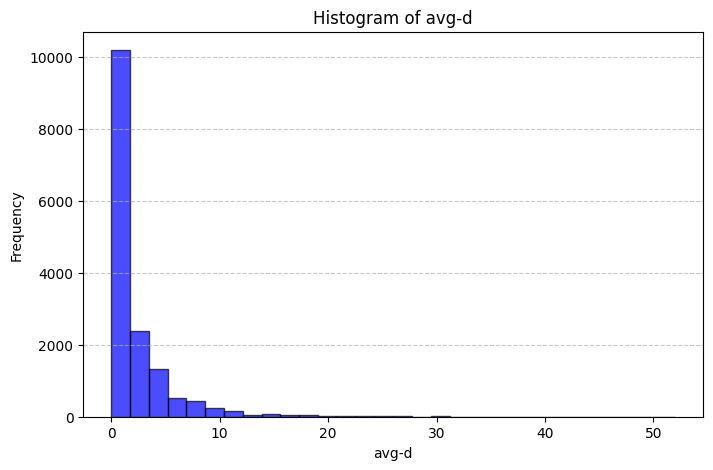

In [251]:
plothist(authstat,"avg-d")

In [253]:
mods_d=[]
E_sum=[]
for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))
    # plothist(test_df, "E")
    X=test_df[["pij_t",'log(cij)','E']].fillna(0)
    y=test_df["ytij"]
    print()
    temp_e=test_df[["Author","Coauthor","E"]].drop_duplicates()['E'].value_counts().reset_index()
    temp_e["start"]=i-10
    temp_e["end"]=i
    E_sum.append(temp_e)
    mods_d.append(logi_mod(X,y, False,1))

#########################################
1950 to 1959 inclusive
#########################################

(926, 2)

Logistic Regression Results:
    Variable  Coefficient  Std. Error    z-value   p-value Significance  \
0  Intercept    -0.784528    0.071267 -11.008259  0.000000          ***   
1      pij_t     0.493963    0.461845   1.069544  0.284825                
2   log(cij)    -0.546676    0.530639  -1.030220  0.302907                

     t-value  p_values_t Significance_t  
0 -11.008259    0.000000            ***  
1   1.069544    0.285104                 
2  -1.030220    0.303176                 
Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81       635
           1       1.00      0.00      0.00       291

    accuracy                           0.69       926
   macro avg       0.84      0.50      0.41       926
weighted avg       0.78      0.69      0.56       926

Confusion Matrix:
[[635   0]
 [291

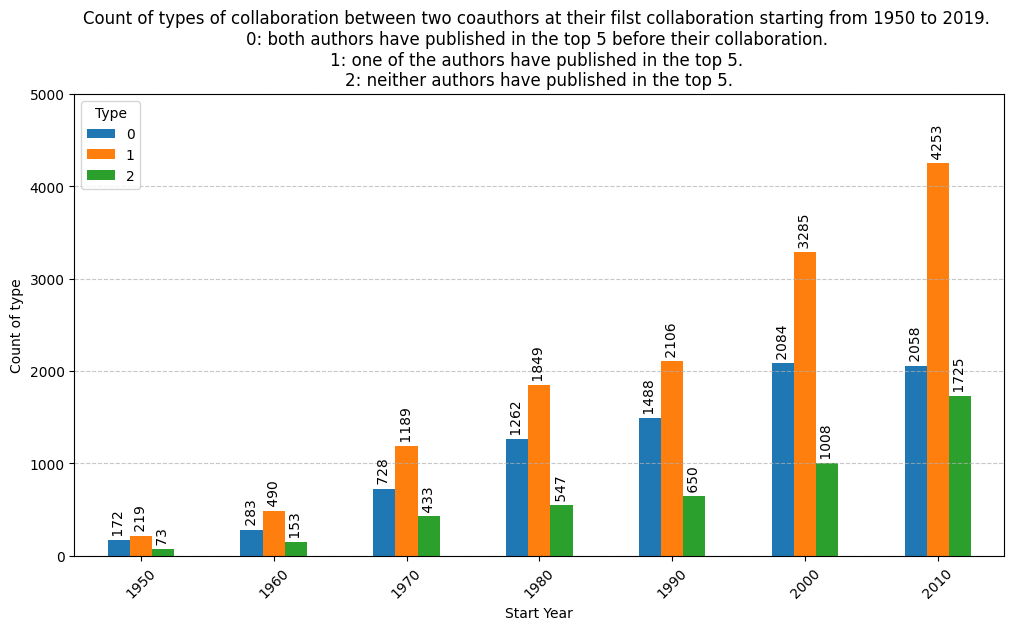

In [254]:

# Pivoting data for better visualization
df_pivot = pd.concat(E_sum).pivot(index="start", columns="E", values="count")

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(kind="bar", stacked=False, figsize=(12, 6), ax=ax)

for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f" {height}",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

ax.set_xlabel("Start Year")
ax.set_ylabel("Count of type")
ax.set_title("Count of types of collaboration between two coauthors at their filst collaboration starting from 1950 to 2019. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index,rotation=45)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0,5000)
# Show the plot
plt.show()

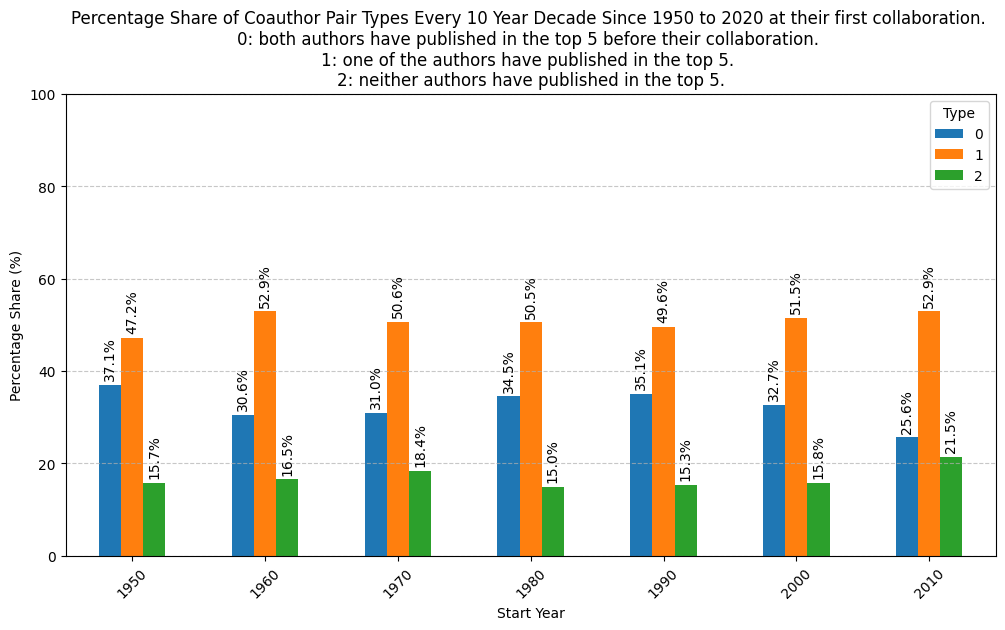

In [255]:
df_pivot_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot_percentage.plot(kind="bar", stacked=False, ax=ax)

# Adding percentage labels above the bars
for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f"{height:.1f}%",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

# Formatting the plot
ax.set_xlabel("Start Year")
ax.set_ylabel("Percentage Share (%)")
ax.set_title("Percentage Share of Coauthor Pair Types Every 10 Year Decade Since 1950 to 2020 at their first collaboration. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.set_ylim(0, 100)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [256]:
print_latex_format(mods_d)


\makecell[l]{Intercept}&\makecell[c]{-0.784528***\\(0.071267)\\0.0} & \makecell[c]{-0.85113***\\(0.052955)\\0.0}& \makecell[c]{-0.917111***\\(0.032639)\\0.0}& \makecell[c]{-1.153684***\\(0.026391)\\0.0}& \makecell[c]{-1.195499***\\(0.024499)\\0.0}& \makecell[c]{-1.150995***\\(0.02064)\\0.0}& \makecell[c]{-0.294388***\\(0.01748)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.493963\\(0.461845)\\0.284825} & \makecell[c]{0.216086\\(0.199551)\\0.278869}& \makecell[c]{-0.080001\\(0.076923)\\0.29833}& \makecell[c]{0.162731**\\(0.055762)\\0.003519}& \makecell[c]{0.042526\\(0.048635)\\0.381913}& \makecell[c]{0.052675\\(0.03997)\\0.187551}& \makecell[c]{0.028203\\(0.033793)\\0.403964}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.546676\\(0.530639)\\0.302907} & \makecell[c]{-0.249766\\(0.225607)\\0.268256}& \makecell[c]{-0.017314\\(0.071862)\\0.809608}& \makecell[c]{-0.392281***\\(0.062087)\\0.0}& \makecell[c]{-0.479573***\\(0.049536)\\0.0}& \makecell[c]{-0.590155***\\(0.040875)\\0.0}& \makecell[c]{

In [257]:
df_f.columns

Index(['Author', 'Coauthor', 'tij', 'ytij', 'tij_1', 'tij_2', 'tij_0', 'tij-1',
       'distance', 'pij_t', 'cij_t', 'A', 'C', 'E', 'avg_p', 'abs_p', 'avg_c',
       'abs_c', 'aff_js'],
      dtype='object')

In [286]:
mods_e=[]

for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 1))

#########################################
1950 to 1959 inclusive
#########################################

(926, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error    z-value       p-value Significance  \
0  Intercept    -0.882893    0.078959 -11.181678  0.000000e+00          ***   
1      pij_t     0.597529    0.461862   1.293739  1.957556e-01                
2   log(cij)    -0.529807    0.527940  -1.003537  3.156020e-01                
3      abs_p     0.335517    0.140906   2.381140  1.725915e-02            *   
4      avg_p    -0.576779    0.154774  -3.726591  1.940874e-04          ***   
5      abs_c     0.935184    0.337165   2.773667  5.542838e-03           **   
6      avg_c    -1.025016    0.348739  -2.939210  3.290504e-03           **   
7     aff_js     0.510428    0.074226   6.876688  6.125989e-12          ***   

     t-value    p_values_t Significance_t  
0 -11.181678  0.000000e+00            ***  
1   1.293739  1.960807e-01                 
2  -1.003

In [287]:
print_latex_format(mods_e)


\makecell[l]{Intercept}&\makecell[c]{-0.882893***\\(0.078959)\\0.0} & \makecell[c]{-1.10047***\\(0.069122)\\0.0}& \makecell[c]{-1.139107***\\(0.040459)\\0.0}& \makecell[c]{-1.363387***\\(0.031554)\\0.0}& \makecell[c]{-1.436278***\\(0.029935)\\0.0}& \makecell[c]{-1.340342***\\(0.024167)\\0.0}& \makecell[c]{-0.353583***\\(0.018912)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.597529\\(0.461862)\\0.195756} & \makecell[c]{0.232774\\(0.214374)\\0.277552}& \makecell[c]{-0.158259*\\(0.078676)\\0.044271}& \makecell[c]{0.17014**\\(0.056735)\\0.00271}& \makecell[c]{0.223042***\\(0.050016)\\8e-06}& \makecell[c]{0.212224***\\(0.03972)\\0.0}& \makecell[c]{0.267736***\\(0.034589)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.529807\\(0.52794)\\0.315602} & \makecell[c]{-0.227157\\(0.245068)\\0.35397}& \makecell[c]{0.34806***\\(0.077904)\\8e-06}& \makecell[c]{0.005218\\(0.064995)\\0.936012}& \makecell[c]{0.086588\\(0.055107)\\0.116125}& \makecell[c]{-0.038613\\(0.044976)\\0.390602}& \makecell[c]{-0

In [ ]:
mods_m=[]

for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_c[(df_c["tij"]<i)&(df_c["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_m.append(logi_mod(X,y, False, 0.1))

#########################################
1950 to 1959 inclusive
#########################################

(1203, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error    z-value   p-value Significance  \
0  Intercept    -4.019966    0.275522 -14.590388  0.000000          ***   
1      pij_t     0.082977    0.279139   0.297260  0.766268                
2   log(cij)     0.527573    0.316367   1.667597  0.095396            .   
3      abs_p     0.098462    0.301202   0.326897  0.743746                
4      avg_p    -0.189516    0.292341  -0.648270  0.516810                
5      abs_c    -0.406894    0.689330  -0.590274  0.555007                
6      avg_c    -0.579904    0.664740  -0.872378  0.383002                
7     aff_js     0.493902    0.150716   3.277042  0.001049           **   

     t-value  p_values_t Significance_t  
0 -14.590388    0.000000            ***  
1   0.297260    0.766320                 
2   1.667597    0.095658              .  
3   0.32

In [259]:
mods_n=[]

for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    mods_n.append(logi_mod(X,y, True, 1))

#########################################
1950 to 1959 inclusive
#########################################

(926, 8)

Logistic Regression Results:
                    Variable  Coefficient    Std. Error       z-value  \
0                  Intercept    -0.852768  1.250725e+06 -6.818192e-07   
1                   log(cij)     0.011673           NaN           NaN   
2                          E     1.115442  1.916540e+06  5.820081e-07   
3                      abs_p    -0.088539  1.392920e-01 -6.356379e-01   
4                      avg_p     0.262797  1.579946e-01  1.663330e+00   
5                      abs_c     0.695639  3.485847e-01  1.995610e+00   
6                      avg_c    -0.577165  3.633258e-01 -1.588562e+00   
7                     aff_js     0.389178  8.653173e-02  4.497517e+00   
8                        E_1    -0.200707  3.035494e+06 -6.611997e-08   
9                        E_2     0.452209  6.070988e+06  7.448689e-08   
10                pij_t_0.25    -0.288923         

/var/folders/5b/5mt219qj6l552yrf3l89xgdh0000gn/T/ipykernel_37858/2419508063.py:81: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(covb))


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- pij_t
Feature names seen at fit time, yet now missing:
- E_1
- E_2
- pij_t_0.25
- pij_t_0.3333333333333333
- pij_t_0.5


In [ ]:
print_latex_format(mods_e)

\makecell[l]{Intercept}&\makecell[c]{-0.563484***\\(0.083945)\\0.0} & \makecell[c]{-0.75543***\\(0.078794)\\0.0}& \makecell[c]{-0.929056***\\(0.044586)\\0.0}& \makecell[c]{-1.193856***\\(0.032718)\\0.0}& \makecell[c]{-1.311699***\\(0.030996)\\0.0}& \makecell[c]{-1.238224***\\(0.024602)\\0.0}& \makecell[c]{-0.289095***\\(0.01898)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.618366\\(0.487783)\\0.204902} & \makecell[c]{0.231614\\(0.552249)\\0.674924}& \makecell[c]{-0.261464*\\(0.112043)\\0.019616}& \makecell[c]{0.117137.\\(0.064591)\\0.06975}& \makecell[c]{0.176512***\\(0.051177)\\0.000563}& \makecell[c]{0.198137***\\(0.039453)\\1e-06}& \makecell[c]{0.261111***\\(0.034389)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.534014\\(0.554187)\\0.335247} & \makecell[c]{-0.186552\\(0.581718)\\0.748444}& \makecell[c]{0.424183***\\(0.108242)\\8.9e-05}& \makecell[c]{0.049611\\(0.072117)\\0.491499}& \makecell[c]{0.100406.\\(0.055864)\\0.072287}& \makecell[c]{-0.034549\\(0.045226)\\0.44491}& \make

In [ ]:
upd_w_lags_10[["Author","Coauthor"]].drop_duplicates().shape

(18385, 2)

In [ ]:
upd_w_lags_10[(upd_w_lags_10["tij_0"]==upd_w_lags_10["tij_1"])&(upd_w_lags_10["tij_2"]==upd_w_lags_10["tij_1"])][["Author","Coauthor"]].drop_duplicates().shape

(9755, 2)

In [263]:
mods_e=[]
E_sum_5=[]
for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f_5[(df_f_5["tij"]<i)&(df_f_5["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    temp_e=test_df[["Author","Coauthor","E"]].drop_duplicates()['E'].value_counts().reset_index()
    temp_e["start"]=i-10
    temp_e["end"]=i
    E_sum_5.append(temp_e)

    mods_e.append(logi_mod(X,y, False, 1 ))

#########################################
1950 to 1959 inclusive
#########################################

(926, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error    z-value       p-value Significance  \
0  Intercept    -0.921514    0.081903 -11.251233  0.000000e+00          ***   
1      pij_t     0.704037    0.447000   1.575027  1.152503e-01                
2   log(cij)    -0.622514    0.502348  -1.239208  2.152686e-01                
3      abs_p     0.569741    0.153317   3.716111  2.023129e-04          ***   
4      avg_p    -0.864043    0.173593  -4.977414  6.443944e-07          ***   
5      abs_c     1.242299    0.511133   2.430481  1.507879e-02            *   
6      avg_c    -1.264339    0.518833  -2.436889  1.481424e-02            *   
7     aff_js     0.567570    0.074603   7.607882  2.775558e-14          ***   

     t-value    p_values_t Significance_t  
0 -11.251233  0.000000e+00            ***  
1   1.575027  1.155944e-01                 
2  -1.239

In [283]:
mods_e=[]
E_sum_5=[]
for i in range(1945,2021,5):
    print("#########################################")
    print(str(i-5)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f_5[(df_f_5["tij"]<i)&(df_f_5["tij"]>=i-5)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))

    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    temp_e=test_df[["Author","Coauthor","E"]].drop_duplicates()['E'].value_counts().reset_index()
    temp_e["start"]=i-5
    temp_e["end"]=i
    E_sum_5.append(temp_e)

    # mods_e.append(logi_mod(X,y, False, 1 ))

#########################################
1940 to 1944 inclusive
#########################################

#########################################
1945 to 1949 inclusive
#########################################

#########################################
1950 to 1954 inclusive
#########################################

#########################################
1955 to 1959 inclusive
#########################################

#########################################
1960 to 1964 inclusive
#########################################

#########################################
1965 to 1969 inclusive
#########################################

#########################################
1970 to 1974 inclusive
#########################################

#########################################
1975 to 1979 inclusive
#########################################

#########################################
1980 to 1984 inclusive
#########################################

############################

In [284]:
E_sum_5

[Empty DataFrame
 Columns: [E, count, start, end]
 Index: [],
 Empty DataFrame
 Columns: [E, count, start, end]
 Index: [],
    E  count  start   end
 0  0    131   1950  1955
 1  1    127   1950  1955
 2  2     41   1950  1955,
    E  count  start   end
 0  1     93   1955  1960
 1  0     79   1955  1960
 2  2     32   1955  1960,
    E  count  start   end
 0  1    152   1960  1965
 1  0    123   1960  1965
 2  2     53   1960  1965,
    E  count  start   end
 0  1    341   1965  1970
 1  0    238   1965  1970
 2  2    100   1965  1970,
    E  count  start   end
 0  1    540   1970  1975
 1  0    417   1970  1975
 2  2    176   1970  1975,
    E  count  start   end
 0  1    675   1975  1980
 1  0    559   1975  1980
 2  2    257   1975  1980,
    E  count  start   end
 0  1    914   1980  1985
 1  0    755   1980  1985
 2  2    256   1980  1985,
    E  count  start   end
 0  1    978   1985  1990
 1  0    963   1985  1990
 2  2    292   1985  1990,
    E  count  start   end
 0  1   10

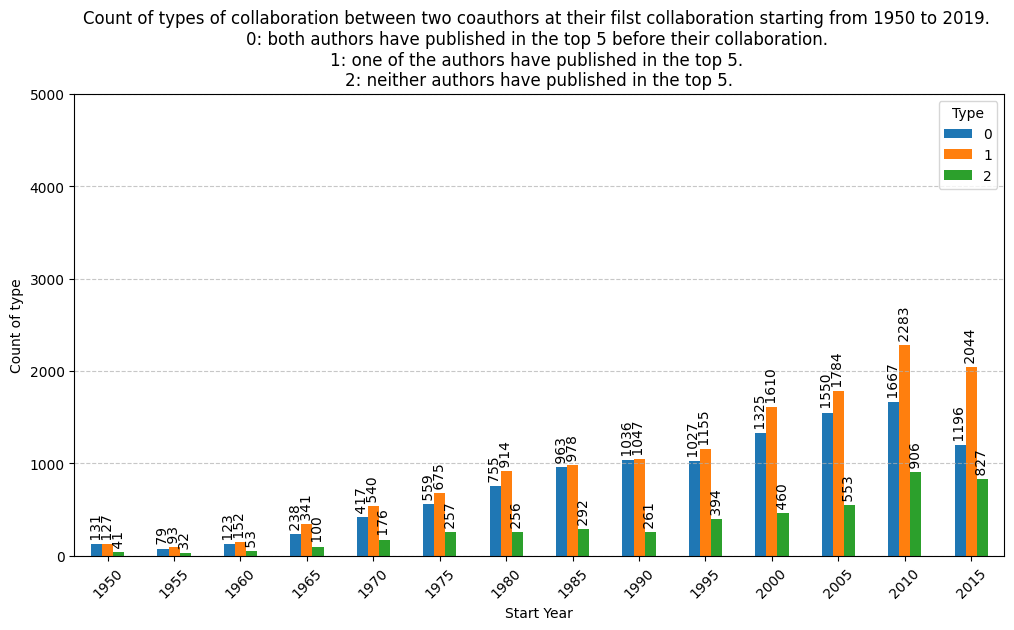

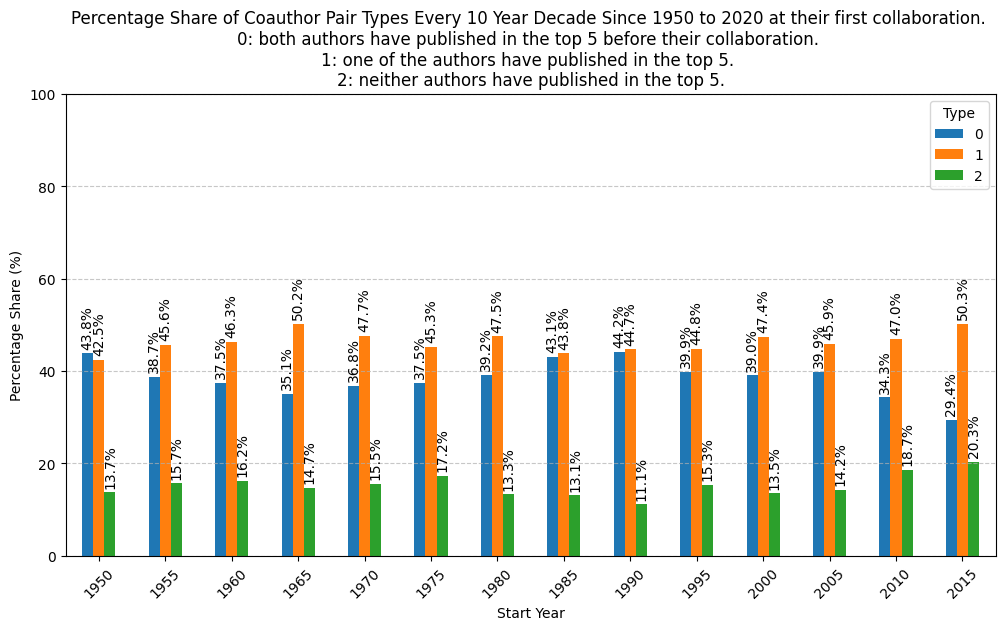

In [ ]:
# Pivoting data for better visualization
df_pivot = pd.concat(E_sum_5).pivot(index="start", columns="E", values="count")

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(kind="bar", stacked=False, figsize=(12, 6), ax=ax)

for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f" {height}",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

ax.set_xlabel("Start Year")
ax.set_ylabel("Count of type")
ax.set_title("Count of types of collaboration between two coauthors at their first collaboration starting from 1950 to 2019. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index,rotation=45)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0,5000)
# Show the plot
plt.show()



df_pivot_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot_percentage.plot(kind="bar", stacked=False, ax=ax)

# Adding percentage labels above the bars
for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f"{height:.1f}%",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

# Formatting the plot
ax.set_xlabel("Start Year")
ax.set_ylabel("Percentage Share (%)")
ax.set_title("Percentage Share of Coauthor Pair Types Every 5 Year Decade Since 1950 to 2020 at their first collaboration. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.set_ylim(0, 100)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [261]:
print_latex_format(mods_e)

\makecell[l]{Intercept}&\makecell[c]{-0.921514***\\(0.081903)\\0.0} & \makecell[c]{-1.059986***\\(0.06524)\\0.0}& \makecell[c]{-1.133858***\\(0.039832)\\0.0}& \makecell[c]{-1.378409***\\(0.031853)\\0.0}& \makecell[c]{-1.405378***\\(0.029186)\\0.0}& \makecell[c]{-1.300823***\\(0.023494)\\0.0}& \makecell[c]{-0.34449***\\(0.018734)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.704037\\(0.447)\\0.11525} & \makecell[c]{0.228471\\(0.219609)\\0.298176}& \makecell[c]{-0.162353*\\(0.078025)\\0.037453}& \makecell[c]{0.180459**\\(0.057561)\\0.001718}& \makecell[c]{0.169356***\\(0.050816)\\0.00086}& \makecell[c]{0.144569***\\(0.040292)\\0.000333}& \makecell[c]{0.226268***\\(0.034991)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.622514\\(0.502348)\\0.215269} & \makecell[c]{-0.201117\\(0.249959)\\0.42105}& \makecell[c]{0.309801***\\(0.076708)\\5.4e-05}& \makecell[c]{-0.10452\\(0.064543)\\0.105362}& \makecell[c]{-0.123539*\\(0.053419)\\0.020741}& \makecell[c]{-0.26132***\\(0.042835)\\0.0}& \makece

In [266]:
mods_e=[]
E_sum_20=[]

for i in range(1970,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f_20[(df_f_20["tij"]<i)&(df_f_20["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c","aff_js"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.0001))
    print(test_df["cij_t"].unique())
    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c","aff_js"]].fillna(0)
    y=test_df["ytij"]
    print()
    temp_e=test_df[["Author","Coauthor","E"]].drop_duplicates()['E'].value_counts().reset_index()
    temp_e["start"]=i-10
    temp_e["end"]=i
    E_sum_20.append(temp_e)
    mods_e.append(logi_mod(X,y, False, 1 ))

#########################################
1960 to 1969 inclusive
#########################################
[0 1]

(1706, 7)

Logistic Regression Results:
    Variable  Coefficient  Std. Error    z-value       p-value Significance  \
0  Intercept    -1.085588    0.068844 -15.768728  0.000000e+00          ***   
1      pij_t     0.203898    0.210166   0.970175  3.319590e-01                
2   log(cij)    -0.188356    0.238862  -0.788556  4.303718e-01                
3      abs_p     0.862692    0.174687   4.938498  7.872643e-07          ***   
4      avg_p    -1.446491    0.211799  -6.829532  8.519185e-12          ***   
5      abs_c     0.022520    0.121657   0.185107  8.531450e-01                
6      avg_c    -0.296217    0.128748  -2.300752  2.140566e-02            *   
7     aff_js     0.678499    0.060642  11.188570  0.000000e+00          ***   

     t-value    p_values_t Significance_t  
0 -15.768728  0.000000e+00            ***  
1   0.970175  3.320971e-01                 
2 

In [ ]:
print_latex_format(mods_e)

\makecell[l]{Intercept}&\makecell[c]{-0.763396***\\(0.080386)\\0.0} & \makecell[c]{-0.973154***\\(0.047148)\\0.0}& \makecell[c]{-1.234341***\\(0.0342)\\0.0}& \makecell[c]{-1.33889***\\(0.031641)\\0.0}& \makecell[c]{-1.274982***\\(0.02529)\\0.0}& \makecell[c]{-0.29075***\\(0.019107)\\0.0}\\\\
\makecell[l]{pij t}&\makecell[c]{0.241372\\(0.54099)\\0.655476} & \makecell[c]{-0.359071**\\(0.119796)\\0.002723}& \makecell[c]{0.084285\\(0.063475)\\0.184228}& \makecell[c]{0.161192**\\(0.050721)\\0.001483}& \makecell[c]{0.201544***\\(0.039508)\\0.0}& \makecell[c]{0.233378***\\(0.03433)\\0.0}\\\\
\makecell[l]{log(cij)}&\makecell[c]{-0.197819\\(0.569755)\\0.728442} & \makecell[c]{0.546784***\\(0.122971)\\9e-06}& \makecell[c]{0.086051\\(0.071115)\\0.226268}& \makecell[c]{0.083978\\(0.054758)\\0.125124}& \makecell[c]{-0.035963\\(0.044383)\\0.417771}& \makecell[c]{-0.143503***\\(0.036986)\\0.000104}\\\\
\makecell[l]{abs p}&\makecell[c]{1.463265***\\(0.222692)\\0.0} & \makecell[c]{1.556855***\\(0.14439

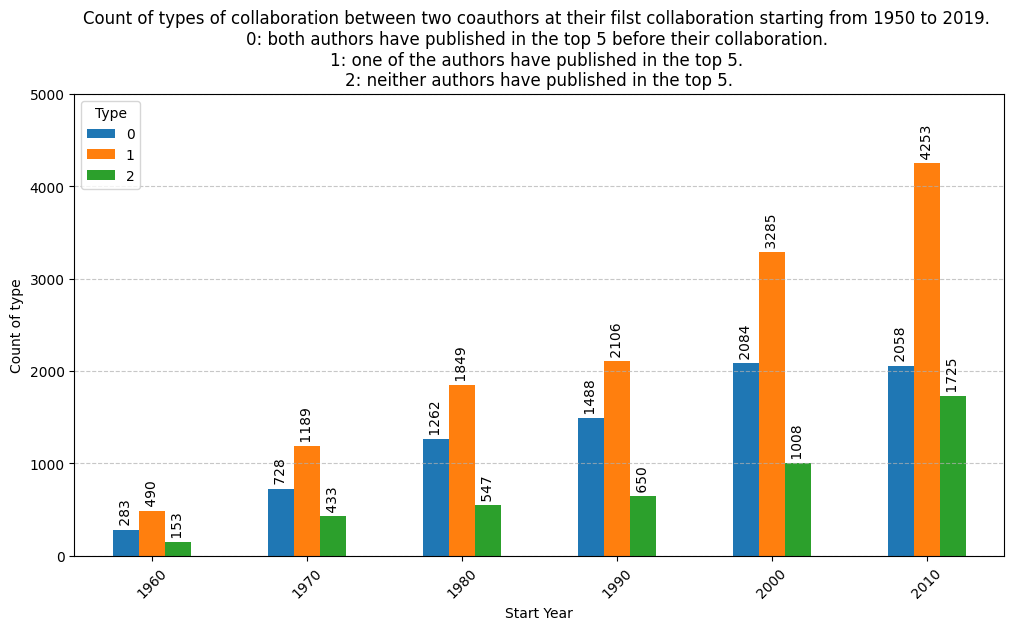

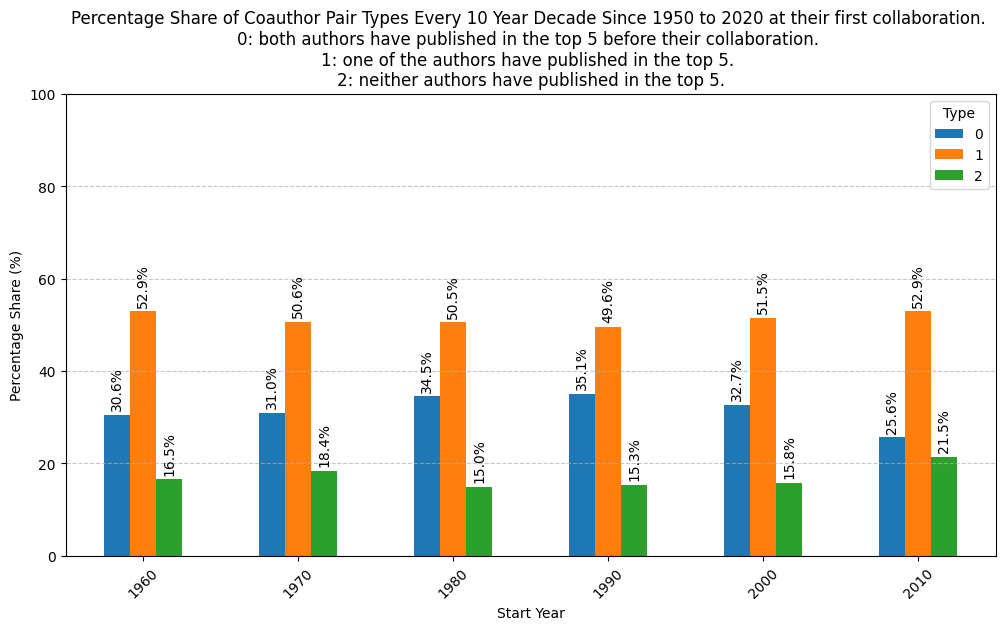

In [267]:
# Pivoting data for better visualization
df_pivot = pd.concat(E_sum_20).pivot(index="start", columns="E", values="count")

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(kind="bar", stacked=False, figsize=(12, 6), ax=ax)

for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f" {height}",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

ax.set_xlabel("Start Year")
ax.set_ylabel("Count of type")
ax.set_title("Count of types of collaboration between two coauthors at their filst collaboration starting from 1950 to 2019. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index,rotation=45)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0,5000)
# Show the plot
plt.show()



df_pivot_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot_percentage.plot(kind="bar", stacked=False, ax=ax)

# Adding percentage labels above the bars
for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 1,  # Y-coordinate (a little above the bar)
                f"{height:.1f}%",  # Formatting percentage
                ha='center', va='bottom', fontsize=10, rotation=90
            )

# Formatting the plot
ax.set_xlabel("Start Year")
ax.set_ylabel("Percentage Share (%)")
ax.set_title("Percentage Share of Coauthor Pair Types Every 10 Year Decade Since 1950 to 2020 at their first collaboration. \n0: both authors have published in the top 5 before their collaboration. \n1: one of the authors have published in the top 5. \n2: neither authors have published in the top 5.")
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.set_ylim(0, 100)
ax.legend(title="Type")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
test_df["cij_t"].unique()

array([ 0,  1,  2,  4,  3,  5,  6,  8,  9,  7, 10, 12, 14, 16, 11, 17, 15,
       13, 18, 20, 19, 37])

In [ ]:
test_df[test_df["pij_t"]>0].head()

,pij_t,cij_t,ytij,tij,tij_0,tij_1,Author,Coauthor,E,avg_p,abs_p,avg_c,abs_c,log(cij)
1,0.090909,1,0,2010,2002,2017,10031,14703,0,37.833333,41.666667,0.928571,0.142857,0.000000
8,0.166667,2,0,2010,2006,2016,10121,10392,0,50.333333,27.000000,1.362500,0.475000,0.693147
9,0.125000,2,0,2010,2006,2012,10121,11069,0,20.416667,32.833333,1.800000,0.400000,0.693147
10,0.333333,1,0,2010,2007,2014,10121,16229,0,36.333333,1.000000,1.550000,0.100000,0.000000
11,0.142857,2,0,2010,2008,2014,10121,16456,0,21.416667,30.833333,1.800000,0.400000,0.693147


In [ ]:
mods_e=[]
for i in range(1960,2021,10):
    print("#########################################")
    print(str(i-10)+' to '+str(i-1) + " inclusive")
    print("#########################################")
    # test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)].reset_index(drop=True)
    test_df=df_f[(df_f["tij"]<i)&(df_f["tij"]>=i-10)][["pij_t",'cij_t',"ytij","tij","tij_0","tij_1","Author", "Coauthor","E","avg_p","abs_p",'avg_c',"abs_c"]].drop_duplicates().reset_index(drop=True)
    # plothist(test_df, "pij_t")
    # plothist(test_df, "E")
    print(test_df["cij_t"].unique())
    test_df["log(cij)"]=np.log(test_df['cij_t'].clip(lower=0.00001))
    test_df=test_df.fillna(0)
    # test_df["pij:log(cij)"]=test_df["pij_t"]*test_df["log(cij)"]
    # test_df.loc[test_df["pij:log(cij)"]==-0,"pij:log(cij)
    # "]=0
    X=test_df[["pij_t",'log(cij)',"E","abs_p", "avg_p",'abs_c',"avg_c"]]
    y=test_df["ytij"]
    print()
    mods_e.append(logi_mod(X,y, False, 0.9 ))

#########################################
1950 to 1959 inclusive
#########################################
[0 1]

(767, 6)

Logistic Regression Results:
    Variable  Coefficient  Std. Error   z-value       p-value Significance  \
0  Intercept    -0.561579    0.081601 -6.881988  5.902390e-12          ***   
1      pij_t     0.621874    0.472540  1.316022  1.881666e-01                
2   log(cij)    -0.539902    0.533521 -1.011961  3.115569e-01                
3      abs_p     0.788227    0.181493  4.343011  1.405431e-05          ***   
4      avg_p    -1.238795    0.199553 -6.207837  5.371898e-10          ***   
5      abs_c     1.239883    0.587517  2.110377  3.482591e-02            *   
6      avg_c    -1.301547    0.591738 -2.199532  2.784009e-02            *   

    t-value    p_values_t Significance_t  
0 -6.881988  1.234124e-11            ***  
1  1.316022  1.885628e-01                 
2 -1.011961  3.118786e-01                 
3  4.343011  1.595736e-05            ***  
4 -6.20

In [ ]:
upd_w_lags_10[(upd_w_lags_10["pij_t"]==0)&(upd_w_lags_10["cij_t"]==0)&(upd_w_lags_10["avg_p"]==0)&(upd_w_lags_10["avg_c"]==0)&(upd_w_lags_10["tij"]<=upd_w_lags_10["tij_1"])].shape
#[["shortest_path_count","pij_t","tij","tij_1"]].head()

(5733, 26)